In [657]:
import torch
SEED = 567816  # change this to get a fully different deterministic run

import os
import random
import numpy as np
import torch
import sklearn
# Python built-in RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNG (CPU + GPU)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Deterministic PyTorch kernels
torch.use_deterministic_algorithms(True)

# Disable hash randomization
os.environ["PYTHONHASHSEED"] = str(SEED)


In [658]:
from jax import tree_util
tree_map = tree_util.tree_map


Using random_state = 567816
y_train_mean (mean of log(y_train_raw)): 0.5733967589120665
Train samples: 16512
Test samples: 4128
Shapes w/ intercept: (16512, 9) (4128, 9)
Bootstrap 1 shape: X=(16512, 9), y=(16512,)
Bootstrap 2 shape: X=(16512, 9), y=(16512,)
Bootstrap 3 shape: X=(16512, 9), y=(16512,)


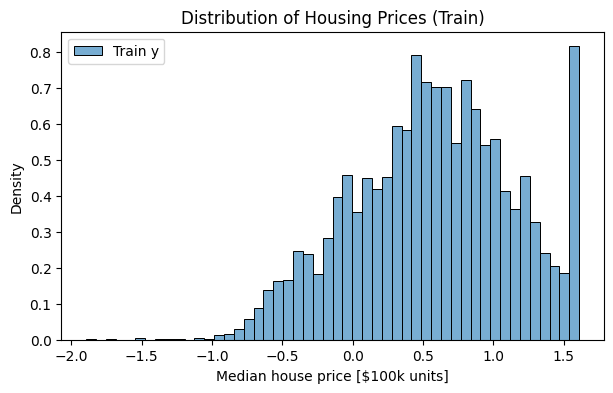

Max y: 5.00001
log(std(y_train)): -0.5601218094396596


In [659]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from ucimlrepo import fetch_ucirepo 
# # --- Load dataset ---
# bike_sharing = fetch_ucirepo(id=275)
california = fetch_california_housing(as_frame=False) 
X = california.data          
y = california.target        

# --- Train/test split ---
import time
print("Using random_state =", SEED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

y_train_raw = y_train.copy()
y_test_raw  = y_test.copy()
# Apply log transform to targets
y_train = np.log(y_train)
y_test  = np.log(y_test)
y_train_mean = y_train.mean()
print("y_train_mean (mean of log(y_train_raw)):", y_train_mean)


#y_train = y_train - y_train_mean
#y_test = y_test - y_train_mean

print("Train samples:", len(y_train))
print("Test samples:", len(y_test))

# --- Standardize features (but NOT target) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Add intercept column AFTER scaling ---
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_scaled = add_intercept(X_train_scaled)
X_test_scaled  = add_intercept(X_test_scaled)

print("Shapes w/ intercept:", X_train_scaled.shape, X_test_scaled.shape)

# --- Bootstraps ---
n_bootstraps = 3
n_train = len(y_train)

base_ss = np.random.SeedSequence(SEED)
child_ss = base_ss.spawn(n_bootstraps)

bootstraps = []
for b, ss in enumerate(child_ss, start=1):
    rng = np.random.default_rng(ss)
    idx = rng.integers(0, n_train, size=n_train, endpoint=False)
    X_bs = X_train_scaled[idx]
    y_bs = y_train[idx]
    bootstraps.append((X_bs, y_bs))
    print(f"Bootstrap {b} shape: X={X_bs.shape}, y={y_bs.shape}")

# --- Plot target distribution ---
plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6, label="Train y")
plt.title("Distribution of Housing Prices (Train)")
plt.xlabel("Median house price [$100k units]")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Debug info ---
y_max = max(y)
print("Max y:", y_max)
print("log(std(y_train)):", np.log(y_train.std()))

X_train_np = X_train_scaled
X_test_np  = X_test_scaled
y_train_np = y_train
y_test_np  = y_test



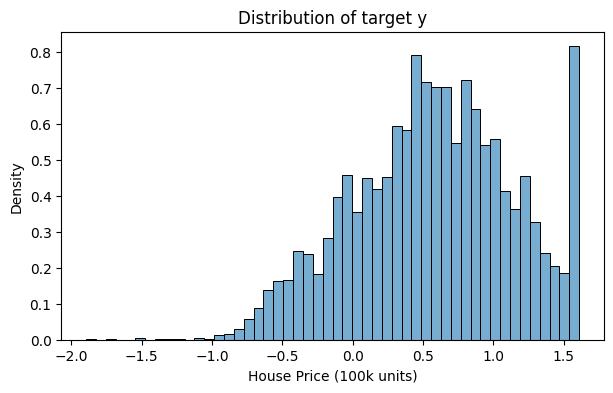

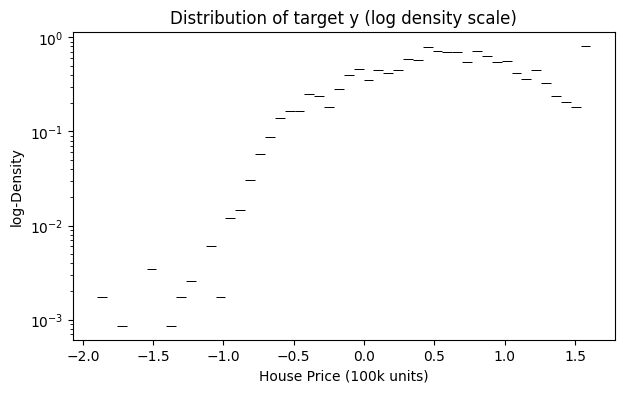

Skewness: -0.17405263590194683
Kurtosis: -0.4413185984312671


/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10893/496774952.py:21: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")
/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10893/496774952.py:21: RuntimeWarning: invalid value encountered in log
  sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")


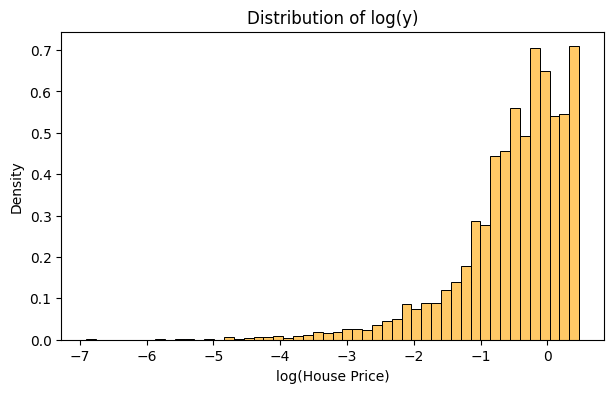

In [660]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6)
plt.title("Distribution of target y")
plt.xlabel("House Price (100k units)")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6, log_scale=(False, True))
plt.title("Distribution of target y (log density scale)")
plt.xlabel("House Price (100k units)")
plt.ylabel("log-Density")
plt.show()
from scipy.stats import skew, kurtosis
print("Skewness:", skew(y_train))
print("Kurtosis:", kurtosis(y_train))
plt.figure(figsize=(7,4))
sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")
plt.title("Distribution of log(y)")
plt.xlabel("log(House Price)")
plt.ylabel("Density")
plt.show()


In [661]:
import numpy as np
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(y_train.reshape(-1,1))
sigma_mmd = np.median(dists)
print(sigma_mmd)

0.5588630592585565


In [662]:
import torch
import numpy as np

def make_conjugate_prior(X_train_np, y_train_np):
    p = X_train_np.shape[1]
    mu_0 = torch.zeros(p, dtype=torch.float32)
    mu_0[0] =  y_train_np.mean()   
    V_0 = torch.eye(p, dtype=torch.float32)
    V_0[0, 0] = 100.0     
    V_0[1:, 1:] = torch.eye(p-1) * 1.0 
    d_0 = torch.tensor(2.1, dtype=torch.float32) 
    var_y = np.var(y_train_np, ddof=1)
    beta_0 = torch.tensor((d_0 - 1.0) * var_y, dtype=torch.float32)
    return {
        'mu_0': mu_0,
        'V_0': V_0,
        'd_0': d_0,
        'beta_0': beta_0
    }


In [663]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalNIG(nn.Module):
    """
    Variational Normal-Inverse-Gamma family for Gaussian linear regression:
        β | σ² ~ Normal(μ, σ² * V)
        σ²     ~ IG(d, β)
    
    Parameters:
        μ      ∈ R^p           : mean of β
        V      ∈ S++^p         : covariance factor for β|σ² (SPD matrix)
        d, β   > 0             : IG shape and scale
    """
    
    def __init__(self, p, init_V=None):
        """
        Args:
            p: dimension of β
            init_V: initial covariance factor V (default: identity)
        """
        super().__init__()
        self.p = p
        
        # -------------------------------------------------
        # 1. Mean of β (unconstrained)
        # -------------------------------------------------
        self.mu = nn.Parameter(torch.zeros(p))
        
        # -------------------------------------------------
        # 2. SPD covariance factor V = L L^T
        #    L is lower-triangular with positive diagonal
        # -------------------------------------------------
        if init_V is None:
            init_V = torch.eye(p)
        
        # Get Cholesky decomposition of initial V
        L_init = torch.linalg.cholesky(init_V)
        
        # Store diagonal as log (for positivity)
        self.L_diag_log = nn.Parameter(torch.log(torch.diag(L_init)))
        
        # Store off-diagonal (unconstrained)
        L_offdiag = torch.tril(L_init, diagonal=-1)
        self.L_offdiag = nn.Parameter(L_offdiag)
        
        # -------------------------------------------------
        # 3. IG parameters d, β (positive via exp(log))
        # -------------------------------------------------
        self.d_log = nn.Parameter(torch.log(torch.tensor(3.0)))
        self.beta_log = nn.Parameter(torch.log(torch.tensor(1.0)))
    
    # ----------------------------
    # Properties ensuring validity
    # ----------------------------
    
    @property
    def d(self):
        """IG shape parameter (d > 0)"""
        return torch.exp(self.d_log)
    
    @property
    def beta_param(self):
        """IG scale parameter (β > 0)"""
        return torch.exp(self.beta_log)
    
    @property
    def L(self):
        """
        Lower triangular Cholesky factor with positive diagonal.
        """
        # Reconstruct L: positive diagonal + off-diagonal
        L_diag = torch.exp(self.L_diag_log)  # Positive diagonal
        L = self.L_offdiag + torch.diag(L_diag)  # Add to off-diagonal
        return L
    
    @property
    def V(self):
        """
        Covariance factor V = L L^T (guaranteed SPD).
        """
        L = self.L  # Get the reconstructed L
        return L @ L.T
    
    def get_params_dict(self):
        """Get all parameters as a dictionary."""
        return {
            'mu': self.mu.detach(),
            'V': self.V.detach(),
            'd': self.d.detach().item(),
            'beta': self.beta_param.detach().item()
        }
    
    def parameters_list(self):
        """
        Return list of parameters for optimizer.
        """
        return [self.mu, self.L_diag_log, self.L_offdiag, 
                self.d_log, self.beta_log]
    
    def initialize_at_prior(self, mu_0, V_0, d_0, beta_0):
        """
        Initialize variational parameters at prior values.
        
        Args:
            mu_0: (p,) prior mean for β
            V_0: (p, p) prior covariance factor
            d_0: scalar prior IG shape
            beta_0: scalar prior IG scale
        """
        with torch.no_grad():
            # Initialize mu
            self.mu.copy_(mu_0)
            
            # Initialize V via Cholesky
            L_prior = torch.linalg.cholesky(V_0)
            self.L_diag_log.copy_(torch.log(torch.diag(L_prior)))
            self.L_offdiag.copy_(torch.tril(L_prior, diagonal=-1))
            
            # Initialize IG parameters (handle both tensors and scalars)
            # ✅ FIX: Ensure proper scalar tensor conversion
            d_0_tensor = torch.as_tensor(d_0, dtype=torch.float32)
            beta_0_tensor = torch.as_tensor(beta_0, dtype=torch.float32)
            
            # Take log and copy (ensuring 0-dimensional tensors)
            self.d_log.copy_(torch.log(d_0_tensor).reshape(()))
            self.beta_log.copy_(torch.log(beta_0_tensor).reshape(()))


    def sample(self, num_samples=1):
        """
        Draw num_samples from q(β, σ²):
            σ² ~ IG(d, β_param)
            β | σ² ~ N(μ, σ² V)
        
        Returns:
            beta_samples: (num_samples, p)
            sigma2_samples: (num_samples,)
        """
        device = self.mu.device
        d = self.d
        beta_scale = self.beta_param  # IG(d, beta_scale)

        # Sample τ = 1/σ² ~ Gamma(shape=d, rate=beta_scale)
        gamma_dist = torch.distributions.Gamma(concentration=d, rate=beta_scale)
        tau = gamma_dist.rsample((num_samples,))  # (S,)
        sigma2 = 1.0 / tau                        # (S,)

        # Sample β | σ² ~ N(μ, σ² V), using Cholesky
        L = self.L  # (p, p)
        eps = torch.randn(num_samples, self.p, device=device)  # (S, p)
        base = eps @ L.T                                       # (S, p)

        sigma_sqrt = torch.sqrt(sigma2).unsqueeze(-1)          # (S, 1)
        beta_samples = self.mu + sigma_sqrt * base             # (S, p)

        return beta_samples, sigma2



In [664]:
import torch

def exact_nig_posterior(X, y, mu_0, V_0, d_0, beta_0):
    X = torch.as_tensor(X, dtype=torch.float32)
    y = torch.as_tensor(y, dtype=torch.float32)

    mu_0   = torch.as_tensor(mu_0, dtype=torch.float32)
    V_0    = torch.as_tensor(V_0, dtype=torch.float32)
    d_0    = torch.as_tensor(d_0, dtype=torch.float32)
    beta_0 = torch.as_tensor(beta_0, dtype=torch.float32)

    n, p = X.shape
    V0_inv = torch.linalg.inv(V_0)
    XtX    = X.T @ X

    Vn_inv = V0_inv + XtX
    V_n    = torch.linalg.inv(Vn_inv)
    mu_n = V_n @ (V0_inv @ mu_0 + X.T @ y)
    d_n = d_0 + 0.5 * n
    yTy        = (y @ y)
    mu0_term   = mu_0 @ (V0_inv @ mu_0)
    mun_term   = mu_n @ (Vn_inv @ mu_n)

    beta_n = beta_0 + 0.5 * (yTy + mu0_term - mun_term)

    return mu_n, V_n, d_n, beta_n


In [665]:
class ExactNIG:
    def __init__(self, mu, V, d, beta):
        self.mu = mu
        self.V = V
        self.d = d
        self.beta_param = beta


In [666]:
import torch
import torch

def expected_nll_loss(X, y, q_mu, q_V, q_d, q_beta):
    n = X.shape[0]
    
    const = (n / 2) * torch.log(torch.tensor(2 * torch.pi))
    psi_d = torch.digamma(q_d)
    expected_log_sigma2 = torch.log(q_beta) - psi_d
    log_term = (n / 2) * expected_log_sigma2
    
    # Part A: Residual at mean (SSR)
    residual = y - X @ q_mu  # (n,)
    ssr = (residual ** 2).sum()  # Sum of squared residuals
    
    # Part B: Trace term (uncertainty in β)
    XtX = X.T @ X  # (p, p)
    trace_term = torch.trace(XtX @ q_V)
    
    # Part C: Expected inverse variance
    expected_inv_sigma2 = q_d / q_beta
    
    squared_error_term = 0.5 * (expected_inv_sigma2 * ssr + trace_term)
    
    expected_nll = const + log_term + squared_error_term
    
    return expected_nll 

# def beta_loss_regression(X, y, beta_vec, sigma2, beta_div):
#     #sigma2 = torch.clamp(sigma2, min=1e-8)
#     mu = X @ beta_vec           
#     resid2 = (y - mu) ** 2      
#     b = beta_div
#     c = (2 * torch.pi * sigma2) ** (-(b - 1) / 2)  
#     term1 = -(1.0 / (b - 1.0)) * c * torch.exp(-0.5 * (b - 1.0) * resid2 / sigma2)
#     term2 = (1.0 / (b ** 1.5)) * c                # integral term, same for all i

#     return (term1 + term2).sum()

# def expected_beta_loss(X, y, q_mu, q_V, q_d, q_beta, beta_div):
#     """
#     Compute E_q[ℓ^(β)(y, X, β, σ²)] for closed-form GVI.
    
#     This is the expectation of beta_loss_regression over q(β, σ²).
    
#     Args:
#         X: (n, p) features
#         y: (n,) targets
#         q_mu: (p,) variational mean for β
#         q_V: (p, p) variational covariance factor for β|σ²
#         q_d: scalar, IG shape parameter
#         q_beta: scalar, IG scale parameter
#         beta_div: β divergence parameter (0 < β < 1)
    
#     Returns:
#         Expected loss (scalar)
#     """
#     b = beta_div
#     n = X.shape[0]
    
#     # ============================================================
#     # TERM 2: E_q[β^(-3/2) · (2πσ²)^(-(β-1)/2)]
#     # ============================================================
#     # This one is easy! It factors as:
#     # β^(-3/2) · (2π)^(-(β-1)/2) · E_q[(σ²)^(-(β-1)/2)]
    
#     # Moment of Inverse Gamma: E[(σ²)^(-α)] = β_param^α · Γ(d+α)/Γ(d)
#     alpha = -(b - 1) / 2
    
#     # Use torch gamma function
#     gamma_ratio = torch.exp(
#         torch.lgamma(q_d - alpha) - torch.lgamma(q_d)
#     )
#     moment_ig = (q_beta ** alpha) * gamma_ratio
    
#     const = (b ** (-1.5)) * ((2 * torch.pi) ** alpha)
#     expected_term2 = n * const * moment_ig  # Same for all n points
    
#     b = beta_div
#     a = q_d
#     B = q_beta

#     n, p = X.shape

#     const1 = -(2 * torch.pi) ** (-(b - 1) / 2) / (b - 1)

#     gamma_ratio = torch.exp(
#         torch.lgamma(a + (b - 1) / 2) - torch.lgamma(a)
#     )
#     power = a + (b - 1) / 2

#     term1 = 0.0

#     for i in range(n):
#         xi = X[i]
#         yi = y[i]

#         m_i = yi - xi @ q_mu
#         xVx = xi @ q_V @ xi

#         infl = 1.0 + (b - 1.0) * xVx   # NOT sqrt
#         if infl.item() <= 0:
#             print("NEGATIVE infl!", infl.item(), "xVx=", xVx.item())

#         sqrt_infl = torch.sqrt(infl)

#         # correct "c_i" term
#         c_i = 0.5 * (b - 1.0) * m_i**2 / infl

#         # correct IG factor
#         ig_factor = (B ** a) * gamma_ratio / ((B + c_i) ** power)

#         # correct final term
#         term1_i = const1 * (1.0 / sqrt_infl) * ig_factor

#         term1 += term1_i

    
#     return term1 + expected_term2

def expected_beta_loss(X, y, q_mu, q_V, q_d, q_beta, beta_div):
    b = beta_div
    n, p = X.shape
    alpha = -(b - 1) / 2
    gamma_ratio = torch.exp(torch.lgamma(q_d - alpha) - torch.lgamma(q_d))
    moment_ig = (q_beta ** alpha) * gamma_ratio
    const = (b ** (-1.5)) * ((2 * torch.pi) ** alpha)
    expected_term2 = n * const * moment_ig
    const1 = -(2 * torch.pi) ** (-(b - 1) / 2) / (b - 1)
    
    gamma_ratio = torch.exp(
        torch.lgamma(q_d + (b - 1) / 2) - torch.lgamma(q_d)
    )
    power = q_d + (b - 1) / 2
    m = y - X @ q_mu  
    XV = X @ q_V  
    xVx = (XV * X).sum(dim=1)  
    
    infl = 1.0 + (b - 1.0) * xVx  
    sqrt_infl = torch.sqrt(infl) 
    
    c = 0.5 * (b - 1.0) * m**2 / infl 
    
    ig_factor = (q_beta ** q_d) * gamma_ratio / ((q_beta + c) ** power) 
    
    term1 = (const1 * (1.0 / sqrt_infl) * ig_factor).sum() 
    
    return term1 + expected_term2

def gamma_loss_regression(X, y, beta, sigma2, gamma):
    n = y.shape[0]
    gamma_t = torch.tensor(gamma, dtype=X.dtype, device=X.device)
    mu = X @ beta
    r2 = (y - mu)**2
    log_f_gamma = -(gamma_t/2) * torch.log(2 * np.pi * sigma2) \
                  - gamma_t * r2 / (2 * sigma2)
    
    term1 = (
    -(1/gamma_t) * (torch.logsumexp(log_f_gamma, dim=0) 
                    - torch.log(torch.tensor(float(n), device=X.device)))
    # + 0.5 * torch.log(2 * np.pi * sigma2)
    )

    log_int = -(gamma_t/2) * torch.log(2 * np.pi * sigma2) \
              - 0.5 * torch.log(1 + gamma_t) 
    
    term2 = (1/(1+gamma_t)) * log_int
    
    return term1 + term2


In [667]:
import math

# def kl_nig(q_mu, q_V, q_a, q_b, 
#            p_mu, p_V, p_a, p_b):
#     """
#     KL(  NIG(q_mu, q_V, q_a, q_b)  ||  NIG(p_mu, p_V, p_a, p_b)  )
#     """

#     # ----------------------------
#     # KL for sigma^2 ~ IG(a, b)
#     # ----------------------------
#     G_p_a = math.gamma(p_a)
#     G_q_a = math.gamma(q_a)
#     kl_sigma =  (
#         (q_a - p_a) * torch.digamma(q_a)
#         + torch.log((q_b**(p_a + 1))*G_p_a / (q_b*p_b**(p_a)*G_q_a))
#         + p_b * (q_a / q_b)
#         - q_a
#     )

#     # ----------------------------
#     # KL for beta | sigma^2
#     # ----------------------------
#     p = q_mu.numel()

#     p_V_inv = torch.inverse(p_V)

#     sign0, logdet_pV = torch.slogdet(p_V)
#     sign1, logdet_qV = torch.slogdet(q_V)

#     diff = (q_mu - p_mu).unsqueeze(1)

#     kl_beta = 0.5 * (
#         torch.trace(p_V_inv @ q_V)
#         +  (q_a / q_b) * (diff.T @ p_V_inv @ diff).squeeze()
#         - p
#         + (logdet_pV - logdet_qV)
#     )

#     return kl_sigma + kl_beta

def kl_nig(q_mu, q_V, q_a, q_b, p_mu, p_V, p_a, p_b):
    lgamma_p_a = torch.lgamma(p_a)
    lgamma_q_a = torch.lgamma(q_a)
    
    kl_sigma = (
        (q_a - p_a) * torch.digamma(q_a)
        + torch.log(q_b ** (p_a + 1)) + lgamma_p_a 
        - torch.log(q_b) - p_a * torch.log(p_b) - lgamma_q_a
        + p_b * (q_a / q_b)
        - q_a
    )
    p_V_inv = torch.linalg.inv(p_V)
    diff = q_mu - p_mu
    
    kl_beta = 0.5 * (
        torch.trace(p_V_inv @ q_V)
        + diff @ p_V_inv @ diff
        - q_mu.shape[0]
        + torch.logdet(p_V) - torch.logdet(q_V)
    )
    
    return kl_sigma + kl_beta





In [668]:
from torch.utils.data import DataLoader, TensorDataset

def make_minibatches(X_numpy, y_numpy, batch_size=64, shuffle=True, device="cpu"):
    X = torch.tensor(X_numpy, dtype=torch.float32, device=device)
    y = torch.tensor(y_numpy, dtype=torch.float32, device=device)
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False, pin_memory=(device=="cuda"))


In [669]:
import torch
import torch.optim as optim
import numpy as np
def train_gvi_regression(
    X_numpy, y_numpy,
    loss_type="beta",  
    beta_div=1.1,
    gamma_div=0.5,
    steps=1000, 
    lr=1e-3,
    batch_size=64,         
    prior_params=None,
    device="cpu",
):
    if hasattr(X_numpy, "values"): 
        X_numpy = X_numpy.values
    if hasattr(y_numpy, "values"): 
        y_numpy = y_numpy.values
    
    n, p = X_numpy.shape
    
    mu_0   = prior_params["mu_0"].to(device)
    V_0    = prior_params["V_0"].to(device)
    d_0    = prior_params["d_0"].to(device)
    beta_0 = prior_params["beta_0"].to(device)
    
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_numpy, dtype=torch.float32).to(device)
    q = VariationalNIG(p, init_V=V_0).to(device)
    q.initialize_at_prior(mu_0, V_0, d_0, beta_0)

    losses = []
    if loss_type in ["beta", "nll"]:

        opt = torch.optim.Adam(q.parameters(), lr=lr)  

        for step in range(steps):

            opt.zero_grad()
            if loss_type == "beta":
                data_term = expected_beta_loss(
                    X_tensor, y_tensor,
                    q_mu=q.mu, q_V=q.V, q_d=q.d,
                    q_beta=q.beta_param,
                    beta_div=beta_div
                )

            elif loss_type == "nll":
                data_term = expected_nll_loss(
                    X_tensor, y_tensor,
                    q_mu=q.mu, q_V=q.V, q_d=q.d,
                    q_beta=q.beta_param
                )

            kl_term = kl_nig(
                q.mu, q.V, q.d, q.beta_param,
                mu_0, V_0, d_0, beta_0
            )

            obj = data_term + kl_term
            obj.backward()
            opt.step()

            losses.append(obj.item())
            if not torch.isfinite(obj):
                print("\n NaN DETECTED DURING TRAINING")
                print("loss_type =", loss_type)
                print("data_term =", data_term.item())
                print("kl_term   =", kl_term.item())
                print("d         =", q.d.item())
                print("beta      =", q.beta_param.item())
                print("min eig V =", torch.linalg.eigvalsh(q.V).min().item())
                raise RuntimeError("Training exploded")
    elif loss_type == "gamma":

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )

        opt = torch.optim.Adam(q.parameters(), lr=lr)

        step = 0
        while step < steps:
            for Xb, yb in loader:
                K = Xb.shape[0]

                opt.zero_grad()

                beta_samples, sigma2_samples = q.sample(num_samples=100)

                mc_losses = []
                for s in range(100):
                    mc_losses.append(
                        gamma_loss_regression(
                            Xb, yb,
                            beta_samples[s], sigma2_samples[s],
                            gamma=gamma_div
                        )
                    )

                batch_loss = torch.stack(mc_losses).mean()
                data_term = (n / K) * batch_loss

                kl_term = kl_nig(
                    q.mu, q.V, q.d, q.beta_param,
                    mu_0, V_0, d_0, beta_0
                )

                obj = data_term + kl_term
                obj.backward()
                opt.step()

                losses.append(obj.item())
                step += 1
                if step >= steps:
                    break

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    print(f"\nTraining complete: {len(losses)} steps.")
    return q, losses


In [670]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
def crps_gaussian_mixture(weights, means, sigmas, y_obs):
    """
    CRPS for scalar Gaussian mixture (numerically stable)
    
    Uses the energy representation:
    CRPS(F, y) = E[|X - y|] - (1/2)E[|X - X'|]
    
    Args:
        weights: [K] - mixture weights
        means: [K] - scalar means  
        sigmas: [K] - standard deviations
        y_obs: scalar observation
    """
    K = weights.shape[0]
    EPS = 1e-10
    
    # Clamp sigmas to avoid numerical issues
    sigmas = jnp.maximum(sigmas, EPS)
    
    # === Term 1: E[|X - y|] where X ~ mixture ===
    # For each component k: E[|N(μₖ, σₖ²) - y|]
    def term1_component(w_k, mu_k, sigma_k):
        z = (y_obs - mu_k) / sigma_k
        # Clip to avoid overflow in cdf/pdf
        #z = jnp.clip(z, -30.0, 30.0)
        
        # E[|N(μ,σ²) - y|] = σ · [z(2Φ(z) - 1) + 2φ(z) - 1/√π]
        cdf_z = jax.scipy.stats.norm.cdf(z)
        pdf_z = jax.scipy.stats.norm.pdf(z)
        
        crps_component = sigma_k * (
            z * (2.0 * cdf_z - 1.0) + 
            2.0 * pdf_z - 
            1.0 / jnp.sqrt(jnp.pi)
        )
        
        return w_k * crps_component
    
    term1 = jnp.sum(jax.vmap(term1_component)(weights, means, sigmas))
    
    # === Term 2: (1/2)E[|X - X'|] where X, X' ~ mixture independently ===
    # For components i, j: E[|N(μᵢ, σᵢ²) - N(μⱼ, σⱼ²)|]
    # This is E[|Z|] where Z ~ N(μᵢ - μⱼ, σᵢ² + σⱼ²)
    def term2_pair(w_i, mu_i, sigma_i, w_j, mu_j, sigma_j):
        # Difference of two independent Gaussians
        mu_diff = mu_i - mu_j
        sigma_sum_sq = sigma_i**2 + sigma_j**2
        sigma_combined = jnp.sqrt(sigma_sum_sq)
        sigma_combined = jnp.maximum(sigma_combined, EPS)
        
        # E[|N(μ_diff, σ_combined²)|] 
        z = mu_diff / sigma_combined
        #z = jnp.clip(z, -30.0, 30.0)
        
        cdf_z = jax.scipy.stats.norm.cdf(z)
        pdf_z = jax.scipy.stats.norm.pdf(z)
        
        # E[|Z|] = σ_Z · [z(2Φ(z) - 1) + 2φ(z)]
        expected_abs = sigma_combined * (
            z * (2.0 * cdf_z - 1.0) + 
            2.0 * pdf_z
        )
        
        return w_i * w_j * expected_abs
    
    # Compute all pairwise terms
    term2 = 0.5 * jnp.sum(
        jax.vmap(
            jax.vmap(term2_pair, (None, None, None, 0, 0, 0)),
            (0, 0, 0, None, None, None)
        )(weights, means, sigmas, weights, means, sigmas)
    )
    
    crps = term1 - term2
    
    # Numerical safety: return large penalty if NaN
    return jnp.where(jnp.isnan(crps), 1e10, crps)

In [671]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from functools import partial
import numpy as np
import matplotlib.pyplot as plt



def build_gaussian_lr(y0, ts, params, key = None, n_samples=1, add_noise=False):
    if params.ndim == 1:
        beta = params[:-1]
        sigma = jnp.exp(params[-1])
        mean_pred = ts @ beta  
        return mean_pred 
    else:
        betas = params[:, :-1]           
        sigmas = jnp.exp(params[:, -1])    
        means = ts @ betas.T               
        return means



import jax
import numpy as np

import jax.random as jrandom
import jax.numpy as jnp
from functools import partial

def build_func_dict(obs, ts, ls2, y0, func, product=True):
    #normal = lambda x, mu, s2: jnp.exp(jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2))
    normal = lambda x, mu, s2: jnp.exp(jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2 + 0.5 * jnp.log(2*jnp.pi*ls2)))
    lognormal = lambda x, mu, s2: jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2)
    kernel = normal if product else normal0

    def bayes_posterior(params):
        ys = func(y0, ts, params, add_noise=False)  
        if ys.ndim > 1:
            ys = ys[0]
        sigma = jnp.exp(params[-1])
        s2 = sigma**2
        loglik = jnp.sum(
            -0.5 * jnp.log(2 * jnp.pi * s2)
            -0.5 * ((ys - obs)**2) / s2
        )
        logprior = -0.5 * jnp.sum(params**2)
        return loglik + logprior

    def mmd_posterior(params):
            logprior = lognormal(params, 0.0, 1.0)
            sigma = jnp.exp(params[-1])
            s2 = sigma**2
            tj0 = func(y0, ts, params)
            if tj0.ndim > 1:
                tj0 = tj0[0]
            def calculate_V(tj):
                kxy = jax.vmap(kernel, (0, 0, None))(obs, tj, s2 + ls2)
                return jnp.sum(kxy)
        
            def calculate_W(tj1, tj2):
                kxy = jax.vmap(kernel, (0, 0, None))(tj2, tj1, 2 * s2 + ls2)
                return jnp.sum(kxy)
                
            Vs = calculate_V(tj0)
            #Ws = calculate_W(tj0, tj0)
            return Vs# - 0.5 * Ws

    def particle_updates_marginalized(params_set, params_set2=None, sum=True):
        n_particles = params_set.shape[0]
        if params_set2 is None:
            params_set2 = params_set
        params_set2 = jax.lax.stop_gradient(params_set2)

        trajs1 = jax.vmap(func, (None, None, 0))(y0, ts, params_set)
        trajs2 = jax.vmap(func, (None, None, 0))(y0, ts, params_set2)

        sigmas1 = jnp.exp(params_set[:, -1])   
        sigmas2 = jnp.exp(params_set2[:, -1])  
        s2s1 = sigmas1**2
        s2s2 = sigmas2**2
        def calculate_V(obs, tj, s2_i):
            kxy = jax.vmap(kernel, (0, 0, None))(obs, tj, s2_i + ls2)
            return jnp.sum(kxy)

        Vs = jax.vmap(calculate_V, (None, 0, 0))(obs, trajs1, s2s1)
        def calculate_W(tj1, tj2, s2_i, s2_j):
            s2_combined = (s2_i + s2_j) / 2
            kxy = jax.vmap(kernel, (0, 0, None))(tj2, tj1, 2 * s2_combined + ls2)
            return jnp.sum(kxy)
        Ws = jax.vmap(
            jax.vmap(calculate_W, (None, 0, None, 0)),  
            (0, None, 0, None)                           
        )(trajs1, trajs2, s2s1, s2s2)

        Ws = Ws.at[jnp.diag_indices_from(Ws)].set(0.0)
        Ws = jnp.sum(Ws, 1) / jnp.maximum(n_particles - 1, 1)

        if sum:
            return jnp.sum(Vs - Ws)
        return (Vs - Ws)
    
    import jax.scipy.stats as stats

    def crps_posterior(params):
        ys = func(y0, ts, params, add_noise=False)
        if ys.ndim > 1:
            ys = ys[0]
        sigma = jnp.exp(params[-1])
        z = (obs - ys) / sigma
        pdf = stats.norm.pdf(z)
        cdf = stats.norm.cdf(z)
        crps_vals = sigma * (z * (2 * cdf - 1) + 2 * pdf - 1.0 / jnp.sqrt(jnp.pi))
        return -jnp.sum(crps_vals) 

    def crps_mixture_objective(params_set):
        n_particles = params_set.shape[0]
        weights = jnp.ones(n_particles) / n_particles
        trajs = jax.vmap(lambda p: func(y0, ts, p, add_noise=False))(params_set)
        sigmas = jnp.exp(params_set[:, -1])
        if trajs.ndim == 2:
            trajs = trajs[:, :, None]
        def crps_at_time_t(t_idx):
            y_t = obs[t_idx]
            means_t = trajs[:, t_idx, :] 
            if jnp.ndim(y_t) == 0: 
                y_t = jnp.array([y_t])
            
            return crps_gaussian_mixture(weights, means_t, sigmas, y_t)
        
        crps_vals = jax.vmap(crps_at_time_t)(jnp.arange(len(obs)))
        avg_crps = jnp.mean(crps_vals)
        logprior = jnp.mean(-0.5 * jnp.sum(params_set**2, axis=1))
        return -avg_crps + logprior



    func_dict = {
        'bayes': jax.jit(bayes_posterior),
        'mmd-bayes': jax.jit(mmd_posterior),
        'crps-bayes': jax.jit(crps_posterior),
        'pcuq': jax.jit(partial(particle_updates_marginalized, sum=True)),
        'pcuq-crps': jax.jit(crps_mixture_objective),
    }

        
    return func_dict



def mala(func, n_iters, dt0, params_init, reg_const, key, multi=False):
    g0 = jax.value_and_grad(func, 0)
    gfunc = jax.vmap(g0, 0) if multi else jax.value_and_grad(func)
    grad_norms = [] 
    energies = []
    params = params_init
    trace = []
    n_particles = params_init.shape[0] if multi else 1

    def logratio(pold, pnew, dt):
        lold, gold = g0(pold)
        lnew, gnew = g0(pnew)
        lold -= 0.5 * reg_const * jnp.sum(jnp.square(pold))
        lnew -= 0.5 * reg_const * jnp.sum(jnp.square(pnew))
        gold -= reg_const * pold
        gnew -= reg_const * pnew
        
        t1 = lnew - lold
        q1 = -0.25 * jnp.sum(jnp.square(pold - pnew - dt * gnew))
        q2 = -0.25 * jnp.sum(jnp.square(pnew - pold - dt * gold))
        return t1 / reg_const + (q1 - q2) / (reg_const * dt)

    logratio = jax.vmap(logratio, (0, 0, None)) if multi else logratio

    hist = []
    window = 10

    for i in range(n_iters):
        rng, key = jrandom.split(key)
        ll, g = gfunc(params)
        grad_norm = jnp.linalg.norm(g)
        grad_norms.append(float(grad_norm))
        params_new = params + dt0 * g - dt0 * reg_const * params + jnp.sqrt(2 * reg_const * dt0) * jrandom.normal(rng, params.shape)
        rng, key = jrandom.split(key)
        
        energy = -ll
        energy_scalar = jnp.mean(energy)
        energies.append(float(energy_scalar))
        lr = logratio(params, params_new, dt0)
        
        if multi:
            flag = jnp.where(jnp.log(jrandom.uniform(rng, lr.shape)) <= lr)[0]
            params = params.at[flag, :].set(params_new[flag, :])
            hist.append(flag.shape[0] / n_particles)
        else:
            flag = (jnp.log(jrandom.uniform(rng, lr.shape)) <= lr)
            params = params_new if flag else params
            hist.append(flag+0.0)
            
        trace.append(params.copy())


        hist = hist[-window:]

        if len(hist) >= window and (i+1) % window == 0 and i >= 50:
            accept_rate = jnp.mean(jnp.array(hist))
            if hasattr(hist, 'logratios'):  
                recent_lr = jnp.array(hist.logratios[-window:])
                mean_lr = jnp.mean(recent_lr)
                
                if accept_rate < 0.15 and mean_lr < -5.0:
                    dt0 = max(dt0 * 0.7, 1e-6)
                elif accept_rate < 0.2 and mean_lr < -2.0:
                    dt0 = max(dt0 * 0.9, 1e-6)
                elif accept_rate > 0.8 and mean_lr > -0.5:
                    dt0 *= 1.2
                elif accept_rate > 0.6 and mean_lr > -1.0:
                    dt0 *= 1.05
          

        if (i+1) % 100 == 0:
            print('{}: {}'.format(i+1, jnp.mean(jnp.array(hist))))
            if multi:
                log_sigma_val = jnp.mean(params[:, -1])
            else:
                log_sigma_val = params[-1]
            log_sigma_val = jnp.ravel(log_sigma_val)[0]   
            print("log_sigma:", float(log_sigma_val))
            print("norn g:", jnp.linalg.norm(g))

    plt.figure(figsize=(8,4))
    plt.plot(grad_norms)
    plt.title("Gradient Norm Evolution (final)")
    plt.xlabel("Iteration")
    plt.ylabel("‖g‖₂")
    plt.grid(alpha=0.3)
    plt.show()
    plt.figure(figsize=(10, 4))
    plt.plot(energies, label="Energy (−log posterior)")
    plt.title("Energy Evolution ")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    arr = np.array(trace)
    param_means = arr.mean(axis=1) if arr.ndim == 3 else arr
    plt.figure(figsize=(10, 6))
    for j in range(param_means.shape[1]):
        plt.plot(param_means[:, j], label=f"param {j}" if j < 5 else None)
    plt.xlabel("Iteration")
    plt.ylabel("Parameter value")
    plt.title("Final evolution of β and log σ")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()        
    return trace

def langevin(func, n_iters, dt0, params_init, reg_const, key, multi=False):
    gfunc = jax.value_and_grad(func, 0)
    gfunc = jax.vmap(gfunc, 0) if multi else gfunc
    
    params = params_init
    trace = []
    

    for i in range(n_iters):
        rng, key = jrandom.split(key)
        ll, g = gfunc(params)

        params_new = params + dt0 * g - dt0 * reg_const * params + jnp.sqrt(2 * reg_const * dt0) * jrandom.normal(rng, params.shape)
        params = params_new
        
        trace.append(params.copy())

        if (i+1) % 1000 == 0:
            print('{}: {}'.format(i+1, ll))
            
    return trace



In [672]:
import numpy as np
import torch

class BaggedVariationalPosterior:
    """
    Mixture of B variational posteriors q_b with equal weights 1/B.
    Sampling returns an i.i.d. draw from the mixture by partitioning S across components.
    """

    def __init__(self, components, rng=None):
        assert len(components) >= 1, "Need at least one posterior component"
        self.components = components
        self.rng = np.random.default_rng() if rng is None else rng
        # Try to detect device
        self.device = getattr(components[0], "device", None)
        if self.device is None and hasattr(components[0], "m_beta"):
            self.device = components[0].m_beta.device
        if self.device is None:
            self.device = torch.device("cpu")

    def _split_counts(self, S):
        """Randomly assign how many samples each component contributes."""
        B = len(self.components)
        if B == 1:
            return [S]
        probs = np.full(B, 1.0 / B)
        return list(self.rng.multinomial(S, probs))

    def sample_beta(self, S):
        counts = self._split_counts(S)
        betas = []
        for q, n_i in zip(self.components, counts):
            if n_i <= 0:
                continue
            b = q.sample_beta(n_i)
            # ensure (S, p) orientation
            if b.shape[0] < b.shape[1]:
                b = b.T
            betas.append(b.to(self.device))
        if not betas:
            raise RuntimeError("No beta samples drawn — check counts or model definitions.")
        return torch.cat(betas, dim=0)  # (S, p)

    def sample_sigma2(self, S):
        counts = self._split_counts(S)
        sig2 = []
        for q, n_i in zip(self.components, counts):
            if n_i <= 0:
                continue
            s2 = q.sample_sigma2(n_i).to(self.device)
            sig2.append(s2)
        if not sig2:
            raise RuntimeError("No sigma² samples drawn — check counts or model definitions.")
        return torch.cat(sig2, dim=0)



class BaggedPCUQ:
    def __init__(self, components, rng=None):
        assert len(components) >= 1, "Need at least one posterior component"
        self.components = []

        for q in components:
            if isinstance(q, dict):
                beta_s, sig2_s = q["beta_samples"], q["sigma2_samples"]
            else:
                beta_s, sig2_s = q

            # Ensure (S, p) shape for betas
            if beta_s.shape[0] < beta_s.shape[1]:
                beta_s = beta_s.T

            self.components.append((beta_s, sig2_s))

        self.device = self.components[0][0].device
        self.rng = np.random.default_rng() if rng is None else rng

    def sample_empirical(self, S):
        B = len(self.components)
        picks = self.rng.integers(0, B, size=S)

        betas_out, sig2_out = [], []
        for b in range(B):
            idx = np.where(picks == b)[0]
            if idx.size == 0:
                continue

            beta_b, sig2_b = self.components[b]
            n_avail = beta_b.shape[0]
            take = self.rng.integers(0, n_avail, size=idx.size)

            betas_out.append(beta_b[take].to(self.device))
            sig2_out.append(sig2_b[take].to(self.device))

        if not betas_out:
            raise RuntimeError("No samples drawn — all component pools empty or incompatible.")

        beta_cat = torch.cat(betas_out, dim=0)  # [S, p]
        sig2_cat = torch.cat(sig2_out, dim=0)   # [S]
        return beta_cat, sig2_cat


In [673]:
import torch
import numpy as np

def train_pvi(
    model, X_train, y_train,
    steps=1000,
    lr=1e-3,
    n_mc=50,
    lambda_reg=0.1,
    scoring="log",  # "log" or "crps"
    prior_mean_beta=None,
    prior_cov_beta=None,
    prior_cov_inv=None,
    logdet_prior_cov=None,
    alpha0=2.0, beta0=2.0,
    device="cpu",
    verbose=True,
):
    """
    Predictive Variational Inference (PVI) training loop (vectorized version).
    Faster version that avoids Python loops over data points.
    """

    # Move data to device
    X = torch.tensor(X_train, dtype=torch.float32, device=device)
    y = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    N = X.shape[0]

    for t in range(1, steps + 1):
        # =======================================================
        # (1) Monte Carlo samples from variational posterior
        # =======================================================
        beta_samples = model.sample_beta(n_mc)       # [S, p]
        sigma2_samples = model.sample_sigma2(n_mc)   # [S]
        sigma_samples = sigma2_samples.sqrt()        # [S]

        # =======================================================
        # (2) Predictive draws y = Xβ + ε
        # =======================================================
        y_pred = X @ beta_samples.T                  # [N, S]
        eps = torch.randn_like(y_pred) * sigma_samples
        y_draws = y_pred + eps

        # =======================================================
        # (3) Predictive scoring
        # =======================================================
        if scoring == "log":
            # Fully vectorized log predictive density
            comp = -0.5 * ((y - y_pred) ** 2 / sigma2_samples + torch.log(2 * torch.pi * sigma2_samples))
            # logsumexp over mixture components (S samples)
            logp = torch.logsumexp(comp, dim=1) - np.log(n_mc)
            loss_pred = -logp.mean()  # negative log-score

        elif scoring == "crps":
            # Empirical CRPS via pairwise distances (vectorized)
            y_expand = y_draws.unsqueeze(2)  # [N, S, 1]
            diff = torch.abs(y_expand - y_expand.transpose(1, 2))  # [N, S, S]
            term1 = torch.mean(torch.abs(y_draws - y), dim=1)      # [N]
            term2 = 0.5 * torch.mean(diff, dim=(1, 2))             # [N]
            crps_vals = term1 - term2
            loss_pred = crps_vals.mean()                           # scalar
        else:
            raise ValueError("scoring must be 'log' or 'crps'")

        # =======================================================
        # (4) KL regularization
        # =======================================================
        kl_beta = model.kl_divergence_beta(
            model, prior_mean_beta, prior_cov_beta, prior_cov_inv, logdet_prior_cov
        )
        kl_sigma = model.kl_divergence_sigma2(model, alpha0, beta0)
        kl_total = kl_beta + kl_sigma

        # =======================================================
        # (5) Combine and update
        # =======================================================
        loss = loss_pred + lambda_reg * kl_total

        opt.zero_grad()
        loss.backward()
        opt.step()

        if verbose and (t == 1 or t % (steps // 10) == 0):
            print(f"[{t:4d}/{steps}] {scoring.upper()} loss={loss_pred.item():.4f} | KL={kl_total.item():.4f}")

    return model



In [674]:
def train_bootstrap_posteriors(train_fn, X, y, B=20, rng=None, **kwargs):
    """
    Generic bootstrap: returns a list of posteriors for a given training function.
    For VI methods, train_fn returns a model object q with .sample_beta/.sample_sigma2.
    For PCUQ, train_fn returns (beta_samples, sigma2_samples) or a dict.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(y)
    posteriors = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # sample with replacement
        Xb, yb = X[idx], y[idx]
        qb = train_fn(X_np=Xb, y_np=yb, **kwargs)
        posteriors.append(qb)
    return posteriors


In [675]:
import torch
import numpy as np
from torch.distributions import StudentT


def is_nig(q):
    return (
        hasattr(q, "mu") and 
        hasattr(q, "V") and 
        hasattr(q, "d") and 
        hasattr(q, "beta_param")
    )



def closed_form_predictive_nig(q, X_tensor):
    """
    Closed-form Student-t posterior predictive for NIG posterior.
    Compatible with VariationalNIG (mu, V, d, beta_param),
    and also with q objects that have (mu, V, a, b).
    """

    # Ensure no gradients are tracked
    with torch.no_grad():

        mu_post = q.mu
        V_post  = q.V

        # Handle both naming conventions robustly
        a = q.a if hasattr(q, "a") else q.d
        b = q.b if hasattr(q, "b") else q.beta_param

        # Predictive mean
        mu_pred = X_tensor @ mu_post              # (n_test,)

        # Quadratic form x^T V x
        quad = (X_tensor @ V_post * X_tensor).sum(dim=1)

        # Predictive scale^2
        scale2 = (b / a) * (1 + quad)

        df = 2 * a

        dist = torch.distributions.StudentT(
            df=df,
            loc=mu_pred,
            scale=torch.sqrt(scale2)
        )

        # --- MUST DETACH BEFORE NUMPY ---
        pred_mean   = dist.mean.detach().cpu().numpy()
        pred_median = mu_pred.detach().cpu().numpy()  # Student-t median = mean = loc


        # For sample-based interface consistency
        pred_samples = (
            dist.rsample((500,))
            .T.detach()
            .cpu()
            .numpy()
        )

        return pred_mean, pred_median, pred_samples




def posterior_predictive_regression(q, X_test, num_samples=500, seed=0):
    """
    Generate posterior predictive samples for regression.

    Supports:
    - NIG exact posteriors (closed-form predictive)
    - Variational families (MC predictive)
    - Bagging ensembles
    - Pre-computed samples
    """

    # Convert input
    if hasattr(X_test, "values"):
        X_test = X_test.values
    X_tensor = torch.as_tensor(X_test, dtype=torch.float32)

    # Detect device
    if is_nig(q):
        device = q.mu.device
    elif hasattr(q, "sample_beta"):
        device = q.m_beta.device
    else:
        device = torch.device("cpu")

    X_tensor = X_tensor.to(device)

    # ============================
    # ★ CLOSED-FORM NIG BRANCH ★
    # ============================
    if is_nig(q):
        return closed_form_predictive_nig(q, X_tensor)

    # ============================
    # OTHERWISE: MONTE CARLO
    # ============================
    n_test = X_tensor.shape[0]

    if seed is not None:
        g = torch.Generator(device=device).manual_seed(seed)
    else:
        g = None

    with torch.no_grad():
        # --- Standard VI (sample_beta / sample_sigma2) ---
        if hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
            betas = q.sample_beta(num_samples)
            sigma2s = q.sample_sigma2(num_samples)

            means = X_tensor @ betas.T              # (n_test, S)
            noise = torch.randn((n_test, num_samples),
                                 device=device, generator=g)
            noise = noise * torch.sqrt(sigma2s).unsqueeze(0)
            draws = means + noise

        # --- Dict / tuple of samples ---
        elif isinstance(q, (tuple, dict)) or (
            hasattr(q, "beta_samples") and hasattr(q, "sigma2_samples")
        ):
            beta_samples = getattr(q, "beta_samples", q[0])
            sigma2_samples = getattr(q, "sigma2_samples", q[1])

            beta_samples = torch.as_tensor(beta_samples, device=device)
            sigma2_samples = torch.as_tensor(sigma2_samples, device=device)

            S = beta_samples.shape[0]
            if S > num_samples:
                idx = torch.randperm(S, device=device)[:num_samples]
                beta_samples = beta_samples[idx]
                sigma2_samples = sigma2_samples[idx]

            means = X_tensor @ beta_samples.T
            noise = torch.randn(means.shape, device=device,
                                generator=g)
            noise = noise * torch.sqrt(sigma2_samples).unsqueeze(0)
            draws = means + noise

        # --- Bagged components (sample from components) ---
        elif hasattr(q, "components"):
            comps = q.components
            bag_idx = np.random.randint(0, len(comps), size=num_samples)
            beta_list, sigma_list = [], []

            for i in bag_idx:
                c = comps[i]
                beta_list.append(c.sample_beta(1))
                sigma_list.append(c.sample_sigma2(1))

            betas = torch.cat(beta_list, dim=0).to(device)
            sigma2s = torch.cat(sigma_list, dim=0).to(device)

            means = X_tensor @ betas.T
            draws = means + torch.randn_like(means, generator=g) * sigma2s.sqrt().mean()

        else:
            raise ValueError(f"Unsupported posterior type: {type(q)}")

    # Convert draws to numpy and compute summaries
    draws = draws.cpu().numpy()
    pred_mean = draws.mean(axis=1)
    pred_median = np.median(draws, axis=1)

    return pred_mean, pred_median, draws



In [676]:
import numpy as np
import torch
import jax

def to_numpy(x):
    if hasattr(x, "cpu"):              # PyTorch tensor
        return x.cpu().numpy()
    if isinstance(x, jax.Array):       # JAX array
        return np.asarray(np.array(x))
    return np.asarray(x)

def _draw_from_vi_object(q, n):
    """Try to draw beta/sigma2 from a VI object `q` that may or may not implement .sample_*()."""
    
    # 1) If the object exposes sampling methods, use them.
    if hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
        with torch.no_grad():
            betas = to_numpy(q.sample_beta(n))
            sigma2s = to_numpy(q.sample_sigma2(n))
        return betas, sigma2s
    
    # ✅ NEW: Handle VariationalNIG (closed-form GVI)
    if hasattr(q, "mu") and hasattr(q, "V") and hasattr(q, "d") and hasattr(q, "beta_param"):
        with torch.no_grad():
            # Extract parameters
            mu = q.mu
            V = q.V
            d = q.d.item()
            beta_param = q.beta_param.item()
            device = mu.device
            
            # Sample σ² ~ InvGamma(d, β_param)
            from torch.distributions import Gamma
            gamma_dist = Gamma(d, 1.0 / beta_param)
            sigma2_samples = 1.0 / gamma_dist.sample((n,)).to(device)
            
            # Sample β | σ² ~ N(μ, σ²V)
            L = torch.linalg.cholesky(V)
            z = torch.randn(n, mu.shape[0], device=device)
            beta_samples = mu.unsqueeze(0) + torch.sqrt(sigma2_samples).unsqueeze(1) * (z @ L.T)
            
            return to_numpy(beta_samples), to_numpy(sigma2_samples)
    
    # 2) Otherwise, try common parameter names to synthesize samples.
    # ---- beta ~ N(loc, Scale·Scale^T) ----
    beta_loc = getattr(q, "beta_loc", getattr(q, "beta_mu", None))
    beta_L = getattr(q, "beta_scale_tril", getattr(q, "beta_L", None))
    
    if beta_loc is None or beta_L is None:
        # fallback: mean + full cov
        beta_mean = getattr(q, "beta_mean", None)
        beta_cov = getattr(q, "beta_cov", None)
        if beta_mean is not None and beta_cov is not None:
            L = torch.linalg.cholesky(beta_cov + 1e-8*torch.eye(beta_cov.shape[-1], device=beta_cov.device))
            eps = torch.randn(n, beta_mean.shape[-1], device=beta_mean.device)
            betas_t = beta_mean + eps @ L.T
        else:
            raise AttributeError(
                "VI object lacks beta sampler and recognizable beta params "
                "(expected .sample_beta(), or mu/V (VariationalNIG), "
                "or beta_loc/beta_L, or beta_mean/beta_cov)."
            )
    else:
        eps = torch.randn(n, beta_loc.shape[-1], device=beta_loc.device)
        betas_t = beta_loc + eps @ beta_L.T
    
    # ---- sigma^2: try Inv-Gamma or log-normal parameterizations ----
    if hasattr(q, "alpha0") and hasattr(q, "beta0"):
        # InvGamma(alpha0, beta0) ≡ 1 / Gamma(alpha0, rate=beta0)
        gamma = torch.distributions.Gamma(concentration=q.alpha0, rate=q.beta0)
        sigma2_t = 1.0 / gamma.sample((n,))
    elif hasattr(q, "log_sigma2_loc") and hasattr(q, "log_sigma2_scale"):
        epss = torch.randn(n, device=q.log_sigma2_loc.device)
        log_s2 = q.log_sigma2_loc + q.log_sigma2_scale * epss
        sigma2_t = torch.exp(log_s2)
    elif hasattr(q, "log_sigma2"):
        sigma2_t = torch.exp(q.log_sigma2).expand(n)
    elif hasattr(q, "sigma2"):
        sigma2_t = getattr(q, "sigma2").expand(n)
    else:
        raise AttributeError(
            "VI object lacks sigma² sampler and recognizable sigma² params "
            "(expected .sample_sigma2(), or d/beta_param (VariationalNIG), "
            "or alpha0/beta0, or log_sigma2_loc/scale, or log_sigma2/sigma2)."
        )
    
    return to_numpy(betas_t), to_numpy(sigma2_t)

import numpy as np
import torch

import numpy as np
import torch

def sample_posterior(q, num_samples=500):
    """
    Draws posterior samples for beta and sigma^2.

    Supports:
    - dict: {"beta_samples", "sigma2_samples"}
    - tuple: (beta, sigma2) or (beta_samples, sigma2_samples)
    - VariationalNIG model
    """

    # ------------------------------------------------------------
    # CASE 1: dict with precomputed samples
    # ------------------------------------------------------------
    if isinstance(q, dict) and "beta_samples" in q:
        beta_samples = q["beta_samples"]
        sigma2_samples = q["sigma2_samples"]

        S = beta_samples.shape[0]
        if num_samples < S:
            idx = np.random.choice(S, num_samples, replace=False)
            beta_samples = beta_samples[idx]
            sigma2_samples = sigma2_samples[idx]

        return beta_samples, sigma2_samples

    # ------------------------------------------------------------
    # CASE 2: tuple
    #   Could be:
    #      (beta, sigma2)
    #   or
    #      (beta_samples, sigma2_samples)
    # ------------------------------------------------------------
    if isinstance(q, (tuple, list)):
        if len(q) != 2:
            raise ValueError("Tuple posterior must have length 2: (beta, sigma2)")

        beta, sigma2 = q

        # Case 2a: Single point estimate (scalars/vectors)
        if np.ndim(beta) == 1 or torch.is_tensor(beta) and beta.ndim == 1:
            # Repeat to make samples
            beta_samples = np.tile(np.asarray(beta), (num_samples, 1))
            sigma2_samples = np.tile(np.asarray(sigma2), num_samples)
            return beta_samples, sigma2_samples

        # Case 2b: Already samples
        beta_samples = np.asarray(beta)
        sigma2_samples = np.asarray(sigma2)
        S = beta_samples.shape[0]
        if num_samples < S:
            idx = np.random.choice(S, num_samples, replace=False)
            beta_samples = beta_samples[idx]
            sigma2_samples = sigma2_samples[idx]
        return beta_samples, sigma2_samples

    # ------------------------------------------------------------
    # CASE 3: VariationalNIG → generate samples
    # ------------------------------------------------------------
    if hasattr(q, "mu") and hasattr(q, "V"):
        from torch.distributions import Gamma

        p = q.mu.shape[0]

        d = q.d.item()
        beta_param = q.beta_param.item()

        gamma_samples = Gamma(d, beta_param).sample((num_samples,))
        sigma2_samples = 1.0 / gamma_samples

        L = torch.linalg.cholesky(q.V).detach()
        betas = []
        for s2 in sigma2_samples:
            eps = torch.randn(p)
            betas.append(q.mu + torch.sqrt(s2) * (L @ eps))
        beta_samples = torch.stack(betas)

        return beta_samples.detach().cpu().numpy(), sigma2_samples.detach().cpu().numpy()


    # ------------------------------------------------------------
    # Unsupported type
    # ------------------------------------------------------------
    raise TypeError(f"sample_posterior received unsupported type: {type(q)}")



def posterior_moments(q):
    """
    Extract posterior moments for β and σ².
    
    Returns:
        beta_mean, beta_var, sigma2_mean, sigma2_var, sigma2_median
    """
    with torch.no_grad():
        # Handle dict/tuple of samples
        if isinstance(q, (tuple, dict)):
            if isinstance(q, dict):
                beta_samples = q["beta_samples"]
                sigma2_samples = q["sigma2_samples"]
            else:
                beta_samples, sigma2_samples = q
            
            beta_mean = beta_samples.mean(dim=0).cpu().numpy()
            beta_var = beta_samples.var(dim=0, unbiased=False).cpu().numpy()
            
            sigma2_mean = sigma2_samples.mean().cpu().numpy()
            sigma2_var = sigma2_samples.var(unbiased=False).cpu().numpy()
            sigma2_median = sigma2_samples.median().cpu().numpy()
        
        # ✅ NEW: Handle VariationalNIG (closed-form GVI)
        elif hasattr(q, "mu") and hasattr(q, "V") and hasattr(q, "d") and hasattr(q, "beta_param"):
            # Marginal of β is Student-t(μ, scale=β_param·V/d, df=2d)
            # For Student-t with df > 2: mean = location, var = scale² · df/(df-2)
            
            mu = q.mu.cpu().numpy()
            V = q.V.cpu().numpy()
            d = q.d.item()
            beta_param = q.beta_param.item()
            
            # Beta moments (marginal is Student-t)
            beta_mean = mu
            df = 2 * d
            if df > 2:
                # Var[β] = (β_param/d) · V · df/(df-2)
                scale_factor = (beta_param / d) * (df / (df - 2))
                beta_var = np.diag(V) * scale_factor
            else:
                beta_var = np.full_like(mu, np.inf)  # Undefined variance
            
            # Sigma² moments (InvGamma(d, β_param))
            if d > 1:
                sigma2_mean = beta_param / (d - 1)
            else:
                sigma2_mean = np.inf
            
            if d > 2:
                sigma2_var = beta_param**2 / ((d - 1)**2 * (d - 2))
            else:
                sigma2_var = np.inf
            
            # Median of InvGamma (no closed form, approximate)
            # For InvGamma(a, b), mode = b/(a+1)
            sigma2_median = beta_param / (d + 1)
        
        # Handle old-style VI object (mean-field with log-normal sigma²)
        else:
            beta_mean = q.m_beta.detach().cpu().numpy()
            beta_var = torch.exp(2 * q.log_s_beta).detach().cpu().numpy()
            
            m, v = q.m_logsig.detach(), torch.exp(2 * q.log_s_logsig.detach())
            sigma2_mean = torch.exp(m + 0.5 * v).cpu().numpy()
            sigma2_var = ((torch.exp(v) - 1.0) * torch.exp(2*m + v)).cpu().numpy()
            sigma2_median = torch.exp(m).cpu().numpy()
    
    return beta_mean, beta_var, sigma2_mean, sigma2_var, sigma2_median



In [677]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_posteriors_all_betas(results, num_samples=2000, feature_names=None):

    for method, q_list in results.items():
        betas_ref, sigma2_ref = sample_posterior(q_list[0], num_samples=100)
        betas_ref = np.asarray(betas_ref)
        p = betas_ref.shape[1]
        if feature_names is not None and len(feature_names) == p:
            param_names = [f"β{i} ({name})" for i, name in enumerate(feature_names)]
        else:
            param_names = [f"β{i}" for i in range(p)]
        param_names.append("σ²")

        fig, axes = plt.subplots(1, len(param_names), figsize=(4 * len(param_names), 4))
        fig.suptitle(f"Posterior distributions – {method.upper()}", fontsize=14)

        for b, q in enumerate(q_list, 1):
            betas, sigma2s = sample_posterior(q, num_samples=num_samples)
            betas = np.asarray(betas)
            sigma2s = np.asarray(sigma2s)

            for j in range(p):
                sns.kdeplot(
                    betas[:, j],
                    ax=axes[j],
                    fill=True, alpha=0.3,
                    label=f"Bootstrap {b}" if len(q_list) > 1 else "Mean"
                )
                axes[j].set_title(param_names[j])

            sns.kdeplot(
                sigma2s,
                ax=axes[-1],
                fill=True, alpha=0.3,
                label=f"Bootstrap {b}" if len(q_list) > 1 else "Mean"
            )
            axes[-1].set_title("σ²")

        axes[0].legend(fontsize=8)
        plt.tight_layout()
        plt.show()



def plot_posterior_predictive_points(
    results, X_test, y_test,
    num_points=20, num_samples=500,
    trained_on_log=True, centered=False,
    y_train_mean=0.0, seed=SEED,
    fixed_ylim=None, show_residuals=True
):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(y_test), size=num_points, replace=False)

    fig, ax = plt.subplots(figsize=(12, 6))
    y_true = y_test + y_train_mean if centered else y_test
    y_plot = np.exp(y_true) if trained_on_log else y_true

    ax.scatter(idxs, y_plot[idxs], color="black", marker="x", s=60, label="True")

    colors = {
        "nll": "C0",
        "beta": "C1",
        "gamma": "C2",
        "pcuq": "C3",
        "bagged-nll": "C4",
        "bagged-beta": "C5",
        "bagged-gamma": "C6",
        "bagged-pcuq": "C7",
        "pvi-log": "C8",
        "pvi-crps": "C9"
    }

    printed_rows = []

    for method, q_list in results.items():
        for b, q in enumerate(q_list, 1):
            _, _, pred_samples = posterior_predictive_regression(
                q, X_test[idxs], num_samples=num_samples
            )
            if centered:
                pred_samples = pred_samples + y_train_mean
            if trained_on_log:
                pred_samples = np.exp(pred_samples)
            pred_mean = pred_samples.mean(axis=1)
            lower = np.percentile(pred_samples, 2.5, axis=1)
            upper = np.percentile(pred_samples, 97.5, axis=1)

            low_err  = np.clip(pred_mean - lower, 0, None)
            high_err = np.clip(upper - pred_mean, 0, None)
            yerr = np.vstack([low_err, high_err])

            color = colors.get(method.lower(), "gray")

            ax.errorbar(
                idxs, pred_mean,
                yerr=yerr,
                fmt="o", alpha=0.6,
                color=color,
                label=f"{method.upper()} bootstrap {b}" if len(q_list) > 1 else method.upper()
            )

            for j, i in enumerate(idxs):
                printed_rows.append({
                    "Index": int(i),
                    "True": float(y_plot[i]),
                    "Method": method.upper(),
                    "Bootstrap": b,
                    "Pred mean": float(pred_mean[j]),
                    "Pred 2.5%": float(lower[j]),
                    "Pred 97.5%": float(upper[j]),
                })

    ax.set_xlabel("Random test indices")
    ax.set_ylabel("House Price")
    ax.set_title("Posterior Predictive (randomly chosen test points)")
    ax.legend(fontsize=8, ncol=2)
    if fixed_ylim is not None:
        ax.set_ylim(fixed_ylim)
    plt.tight_layout()
    plt.show()

    # ---- DataFrame summary ----
    df_print = pd.DataFrame(printed_rows)
    df_print = df_print.sort_values(["Index", "Method", "Bootstrap"])
    print("\nPredicted means for chosen points:")
    print(df_print.to_string(index=False))

    # ---- Residuals plot ----
    if show_residuals:
        bootstraps = sorted(df_print["Bootstrap"].unique())
        methods = df_print["Method"].unique()

        fig, axes = plt.subplots(
            len(bootstraps), 1, figsize=(8, 4 * len(bootstraps)), sharex=True
        )
        if len(bootstraps) == 1:
            axes = [axes]

        for ax_, b in zip(axes, bootstraps):
            for method in methods:
                df_mb = df_print[
                    (df_print["Bootstrap"] == b) & (df_print["Method"] == method)
                ]
                if df_mb.empty:
                    continue
                residuals = df_mb["True"].values - df_mb["Pred mean"].values
                ax_.scatter(df_mb["True"].values, residuals, alpha=0.7, label=method)
            ax_.axhline(0, color="black", linestyle="--")
            ax_.set_title(f"Residuals vs True (Bootstrap {b})")
            ax_.set_ylabel("Residuals")
            ax_.legend(fontsize=8)
        axes[-1].set_xlabel("True values")
        plt.tight_layout()
        plt.show()

    return df_print




/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10893/2890217685.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta_0 = torch.tensor((d_0 - 1.0) * var_y, dtype=torch.float32)



Training NLL on bootstrap 1...

Training NLL on bootstrap 2...

Training NLL on bootstrap 3...


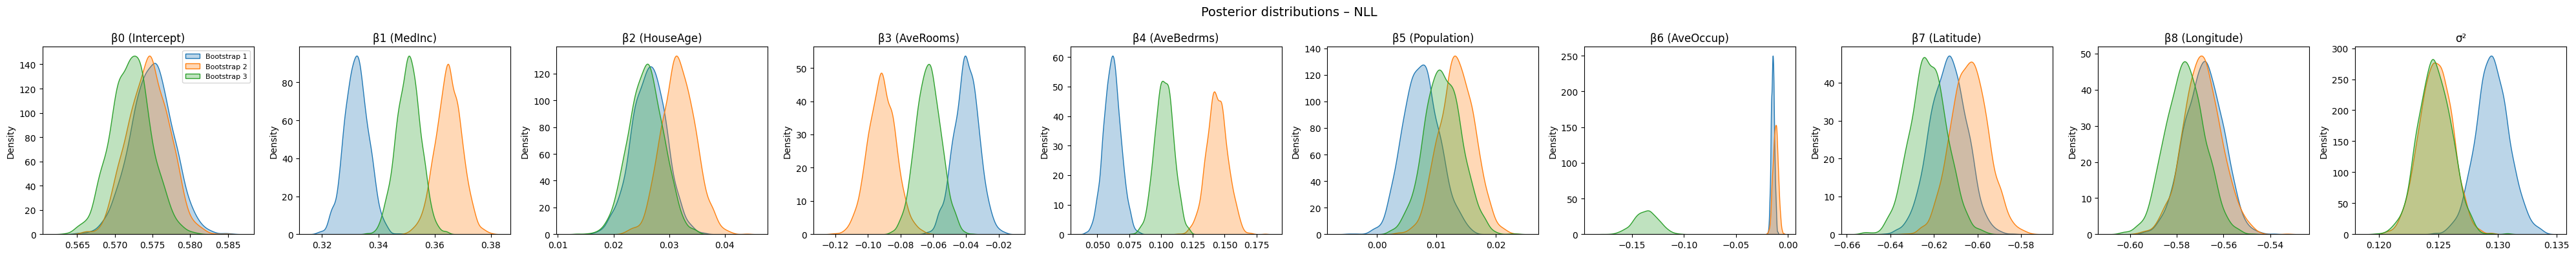

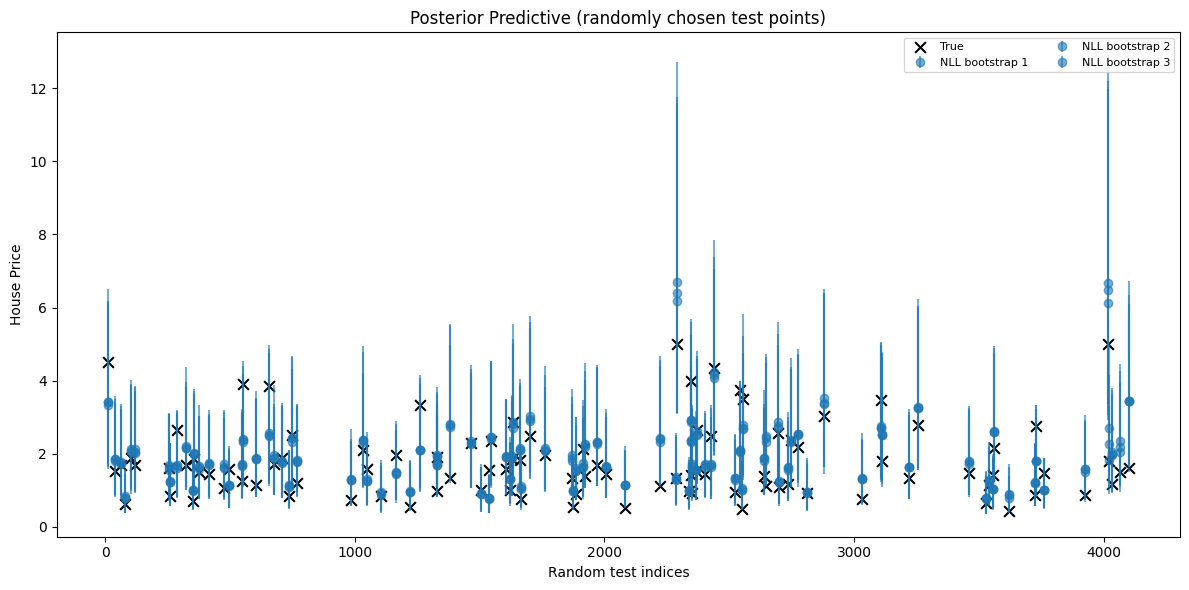


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800    NLL          1   3.348496   1.595370    6.190352
    10 4.51800    NLL          2   3.423451   1.702128    6.506473
    10 4.51800    NLL          3   3.417269   1.651922    6.148599
    37 1.53800    NLL          1   1.872526   0.837710    3.511450
    37 1.53800    NLL          2   1.852439   0.867807    3.584675
    37 1.53800    NLL          3   1.808245   0.827667    3.377627
    62 1.70200    NLL          1   1.751802   0.865519    3.317263
    62 1.70200    NLL          2   1.780031   0.837060    3.363010
    62 1.70200    NLL          3   1.717135   0.786349    3.214836
    80 0.62100    NLL          1   0.837037   0.381446    1.573537
    80 0.62100    NLL          2   0.788052   0.387258    1.437603
    80 0.62100    NLL          3   0.802647   0.390812    1.525845
   104 1.88100    NLL          1   2.057756   0.893159    3.891617
   104 1.88100    NLL     

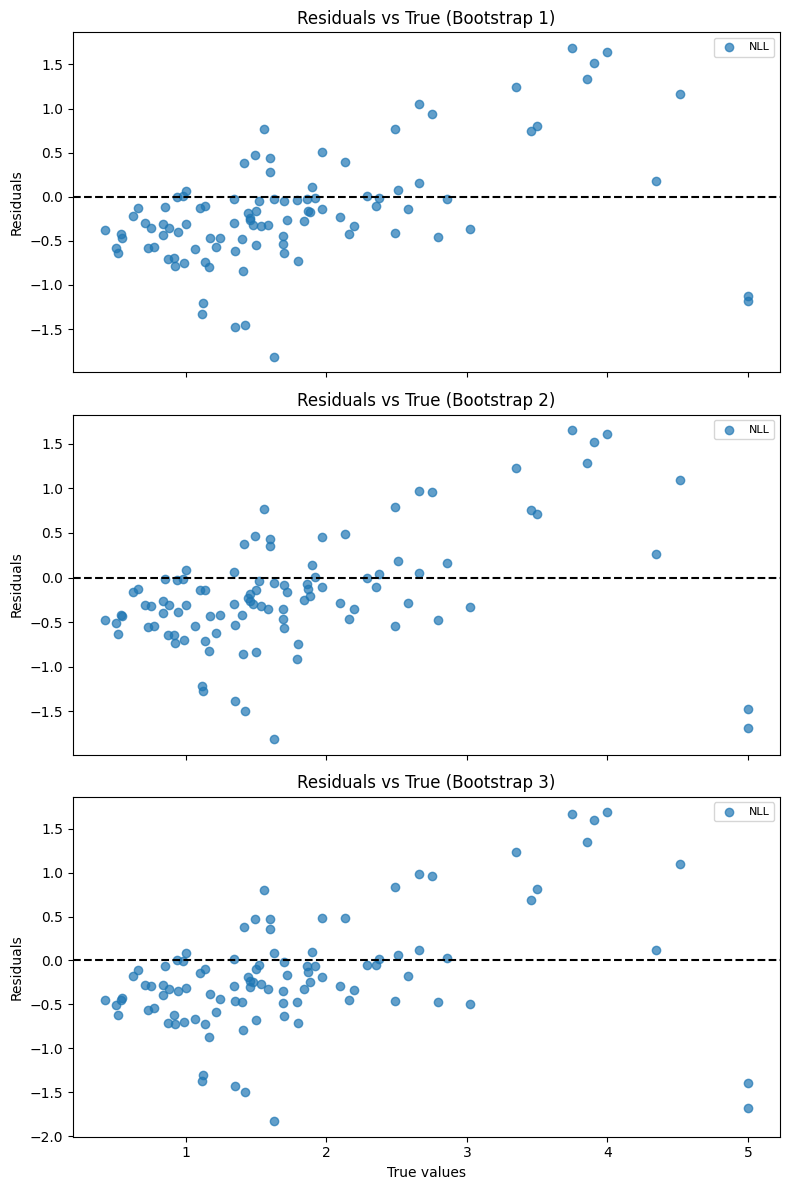


Training BETA on bootstrap 1...

Training complete: 500 steps.

Training BETA on bootstrap 2...

Training complete: 500 steps.

Training BETA on bootstrap 3...

Training complete: 500 steps.


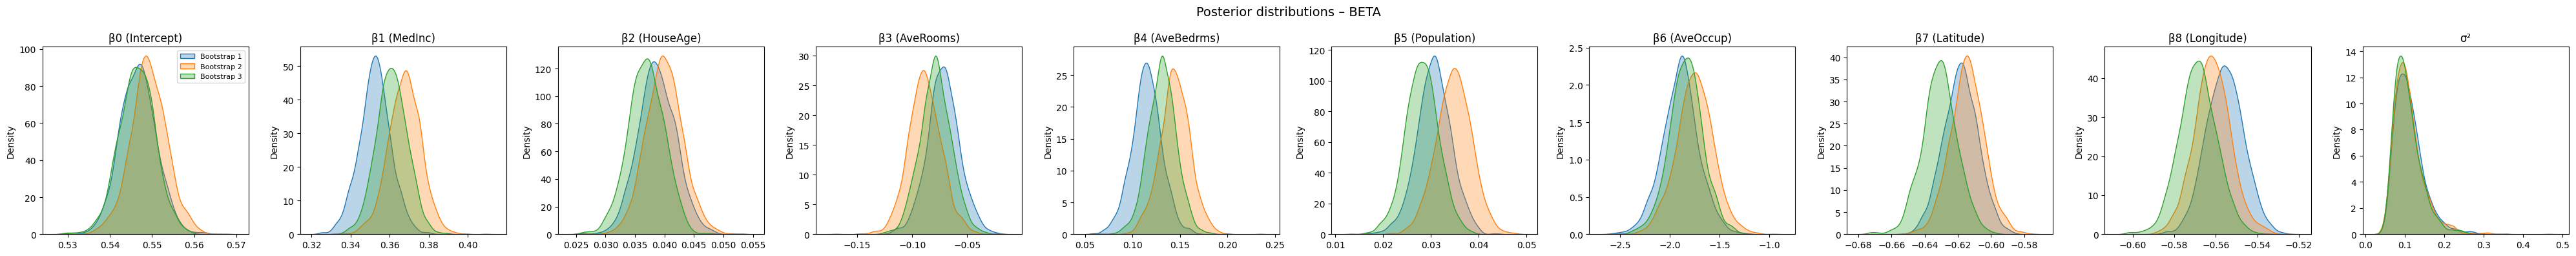

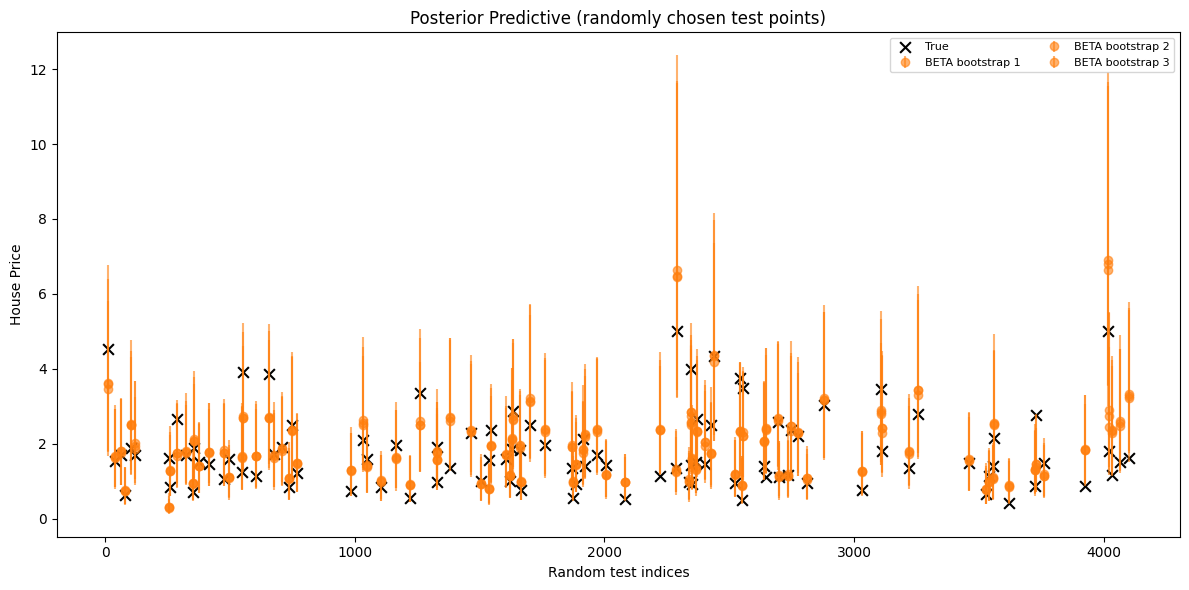


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800   BETA          1   3.583421   1.784078    6.760140
    10 4.51800   BETA          2   3.614592   1.813104    6.407020
    10 4.51800   BETA          3   3.448347   1.670269    5.805697
    37 1.53800   BETA          1   1.677884   0.841000    2.922009
    37 1.53800   BETA          2   1.639588   0.789388    2.938743
    37 1.53800   BETA          3   1.617768   0.835311    3.026551
    62 1.70200   BETA          1   1.758738   0.886288    3.201203
    62 1.70200   BETA          2   1.802413   0.893288    3.184155
    62 1.70200   BETA          3   1.817757   0.904728    3.224847
    80 0.62100   BETA          1   0.743707   0.377852    1.347615
    80 0.62100   BETA          2   0.771910   0.376772    1.374953
    80 0.62100   BETA          3   0.744927   0.357464    1.371210
   104 1.88100   BETA          1   2.496860   1.169825    4.761569
   104 1.88100   BETA     

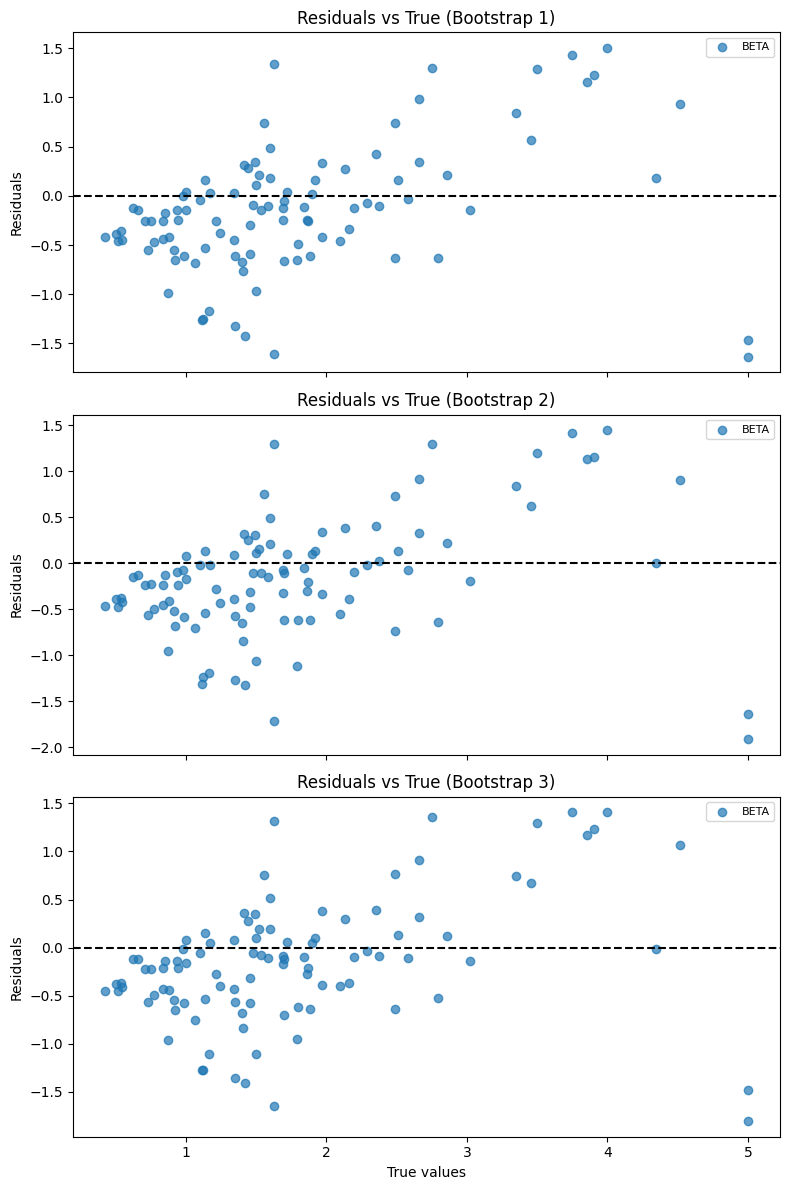


Training GAMMA on bootstrap 1...

Training complete: 2000 steps.

Training GAMMA on bootstrap 2...

Training complete: 2000 steps.

Training GAMMA on bootstrap 3...

Training complete: 2000 steps.


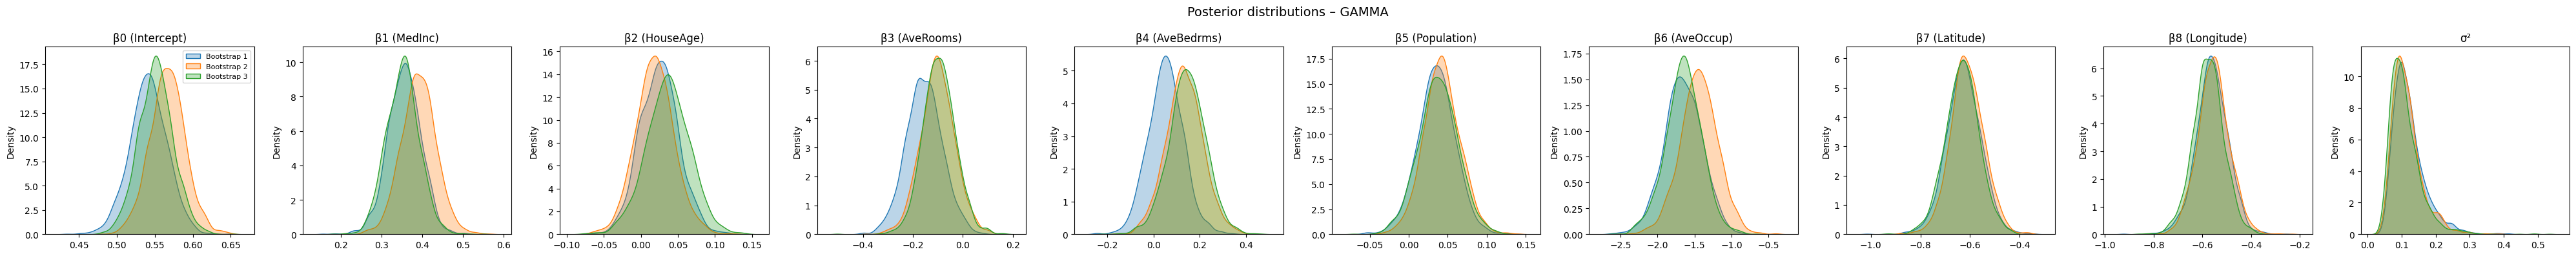

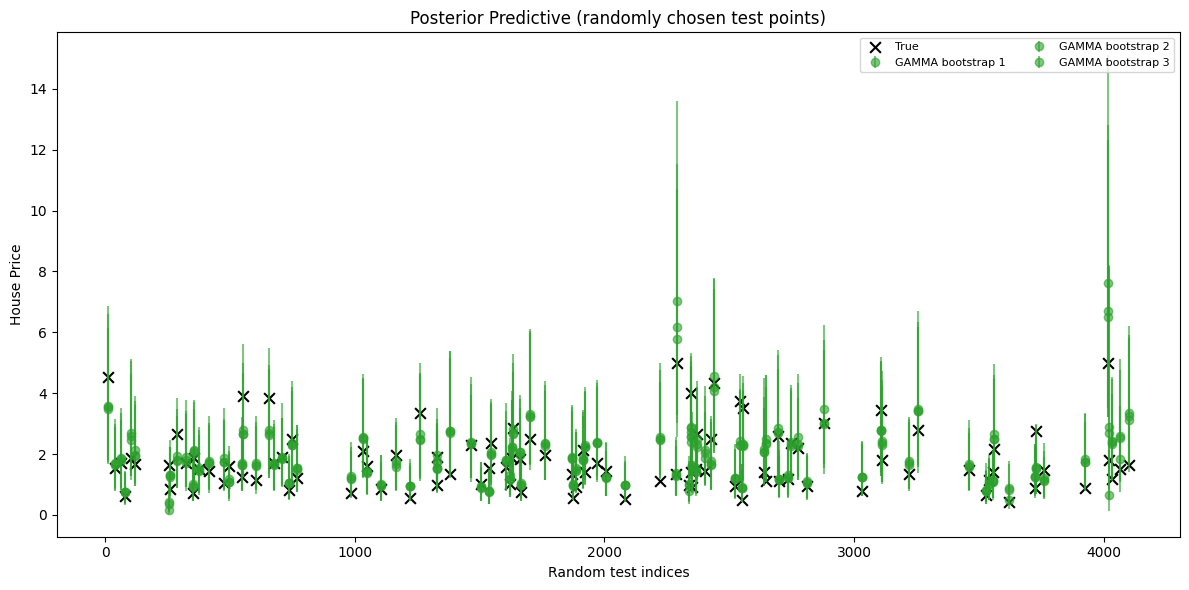


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800  GAMMA          1   3.493672   1.658763    6.603581
    10 4.51800  GAMMA          2   3.570861   1.726491    6.865220
    10 4.51800  GAMMA          3   3.530946   1.807673    6.152703
    37 1.53800  GAMMA          1   1.700474   0.796340    3.149762
    37 1.53800  GAMMA          2   1.676811   0.824221    2.989108
    37 1.53800  GAMMA          3   1.634667   0.873992    2.893626
    62 1.70200  GAMMA          1   1.850319   0.806498    3.506274
    62 1.70200  GAMMA          2   1.764146   0.829499    3.114086
    62 1.70200  GAMMA          3   1.870896   0.885482    3.339104
    80 0.62100  GAMMA          1   0.752806   0.336138    1.431950
    80 0.62100  GAMMA          2   0.740483   0.358499    1.393483
    80 0.62100  GAMMA          3   0.761581   0.388537    1.376552
   104 1.88100  GAMMA          1   2.588953   1.271441    5.128789
   104 1.88100  GAMMA     

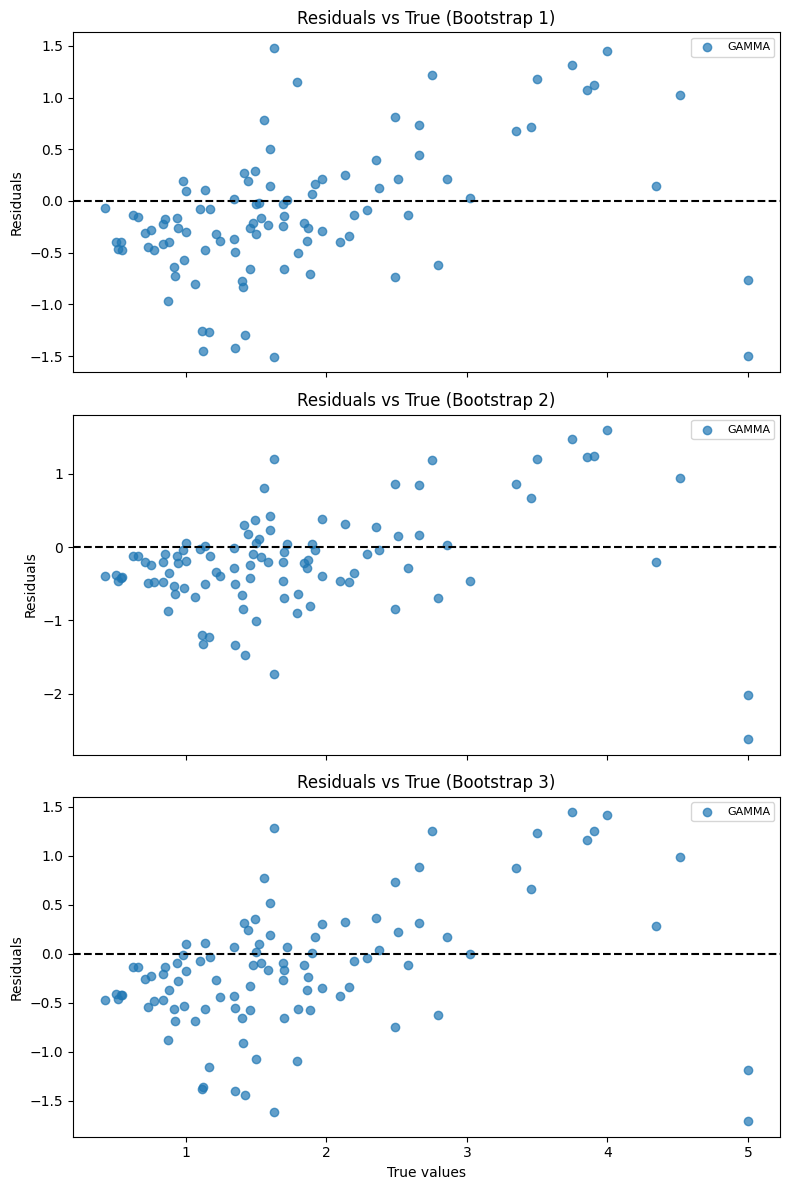


Training PCUQ on bootstrap 1...
100: 0.010000000707805157
log_sigma: -1.022096037864685
norn g: 56.841312
200: 0.010000000707805157
log_sigma: -1.022067904472351
norn g: 56.560894
300: 0.0
log_sigma: -1.0220797061920166
norn g: 69.00517
400: 0.020000001415610313
log_sigma: -1.0220445394515991
norn g: 97.75642
500: 0.030000001192092896
log_sigma: -1.0219885110855103
norn g: 97.29248
600: 0.0
log_sigma: -1.0220551490783691
norn g: 108.941986


KeyboardInterrupt: 

In [678]:
methods = [
    ("nll",   {"beta": None, "gamma": None}),
    ("beta",  {"beta": 1.1,  "gamma": None}),
    ("gamma", {"beta": None, "gamma": 0.1}),
    ("pcuq",  {"beta": None, "gamma": None})#, 
    #("pvi-log", {}),
    #("pvi-crps", {})
]
prior_params_dict = make_conjugate_prior(X_train_np, y_train_np)
feature_names = ["Intercept"] + california.feature_names
trained_results = {}  

for method, params in methods:

    q_list = []

    for j, (X_bs, y_bs) in enumerate(bootstraps, 1):
        print(f"\nTraining {method.upper()} on bootstrap {j}...")
        # if method == "nll":
        #     qj, losses_j = train_gvi_regression(
        #         X_bs, y_bs,
        #         loss_type = "nll",
        #         steps=1000,
        #         lr=1e-2,
        #         prior_params=prior_params_dict,
        #         device="cpu"
        #     )
        if method == "nll":
            mu_n, V_n, d_n, beta_n = exact_nig_posterior(
                X_bs, y_bs,
                prior_params_dict["mu_0"],
                prior_params_dict["V_0"],
                prior_params_dict["d_0"],
                prior_params_dict["beta_0"]
            )

            qj = ExactNIG(mu_n, V_n, d_n, beta_n)
        elif method == "beta":
            qj, losses_j = train_gvi_regression(
                X_bs, y_bs,
                loss_type = "beta",
                beta_div=params["beta"],
                steps=500,
                lr=1e-2,
                prior_params=prior_params_dict,
                device="cpu"
            )
        elif method == "gamma":
            qj, losses_j = train_gvi_regression(
                X_bs, y_bs,
                loss_type="gamma",
                gamma_div=params["gamma"],
                steps=2000,
                lr=1e-2,
                batch_size=64,
                prior_params=prior_params_dict,
                device="cpu"
            )

        elif method == "pcuq":
            key = jrandom.PRNGKey(0)
            func_dict = build_func_dict(
                obs=jnp.array(y_bs),
                ts=jnp.array(X_bs),
                ls2=(sigma_mmd ** 2) / 2,   
                y0=0.0,       
                func=build_gaussian_lr,
                product=True,
            )

            n_features = X_bs.shape[1]
            n_particles = 10                
            reg_const = 1e-3
        
            from numpy.linalg import lstsq
            beta_ls = lstsq(X_bs, y_bs, rcond=None)[0]
            log_sigma_init = jnp.log(jnp.std(y_bs - X_bs @ beta_ls))
            bayes_init = jnp.concatenate([beta_ls, jnp.array([log_sigma_init])])
            
            params_init = jnp.stack([bayes_init] * n_particles, axis=0)
            rng, key = jrandom.split(key)
            params_init += 1e-6 *jrandom.normal(rng, params_init.shape)

            func = func_dict["bayes"]
            rng, key = jrandom.split(key)
            tr_bayes = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init,
                reg_const = reg_const,
                key=rng,
                multi=True,
            )

  
            params_init2 = tr_bayes[-1]
            func = func_dict["mmd-bayes"]
            ys = build_gaussian_lr(0, jnp.array(X_bs), params_init)
            sigma = jnp.exp(params_init[-1])
            s2 = sigma**2
            kernel = lambda x, mu, s2: jnp.exp(jnp.sum(
                -0.5 * jnp.log(2*jnp.pi*s2) 
                - 0.5 * jnp.square(x-mu)/s2 
                + 0.5 * jnp.log(2*jnp.pi*(sigma_mmd ** 2) / 2)
            ))
            rng, key = jrandom.split(key)
            tr_crps = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init2,
                reg_const=reg_const,
                key=rng,
                multi=True,
            )

            params_init3 = tr_crps[-1]
            func = func_dict["pcuq"]


            rng, key = jrandom.split(key)
            tr_pcuq = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init3,
                reg_const=reg_const*0.1,
                key=rng,
                multi=False,      
            )
            trace_arr = np.array(tr_pcuq)         
            flat = trace_arr.reshape(-1, trace_arr.shape[-1])
            beta_samples   = flat[:, :-1]
            sigma2_samples = np.exp(2 * flat[:, -1])
            print("Posterior mean σ²:", sigma2_samples.mean())
            print("Posterior mean β (first 5):", beta_samples.mean(axis=0)[:5])
            qj = {
                "beta_samples": np.array(beta_samples),
                "sigma2_samples": np.array(sigma2_samples),
            }


        else:
            raise RuntimeError("Unknown method")

        q_list.append(qj)
    trained_results[method] = q_list
    plot_posteriors_all_betas({method: q_list}, num_samples=2000, feature_names=feature_names)
    plot_posterior_predictive_points(
        {method: q_list},
        X_test_np, y_test_np,        
        num_points=100, num_samples=5000,
        trained_on_log=True,
        centered=False,
        y_train_mean=y_train_mean,  
        seed=SEED
    )




In [679]:
from scipy.stats import t as student_t
def evaluate_metrics(q_list, X_test, y_test,
                     num_samples=1000, method_name="",
                     trained_on_log=True, centered=False, y_train_mean=0.0,
                     seed=123, max_samples=5000):  # ✅ Add max_samples parameter
    """
    Computes RMSE, NLPD, and CRPS on the RAW y scale when trained_on_log=True.
    
    Args:
        max_samples: Maximum number of samples to use (to prevent memory issues)
    """
    import numpy as np
    from scipy.stats import norm
    from scipy.special import logsumexp
    
    rng = np.random.default_rng(SEED)
    
    # --- CRPS (empirical) with memory protection ---
    def crps_empirical(y, samples_row, max_pairs=2000):
        s = np.asarray(samples_row)

        # If too many samples, subsample ONCE and use the SAME subset for both terms
        n_samples = len(s)
        if n_samples > max_pairs:
            idx = rng.choice(n_samples, size=max_pairs, replace=False)
            s = s[idx]  # overwrite s entirely

        # Both terms now use the same s
        term1 = np.mean(np.abs(s - y))
        term2 = 0.5 * np.mean(np.abs(s[:, None] - s[None, :]))
        return term1 - term2

    
    results = []
    def is_nig_variational(q):
        # Adjust this detector to match your actual VariationalNIG class
        return (
            hasattr(q, "mu")
            and hasattr(q, "V")
            and hasattr(q, "d")
            and hasattr(q, "beta_param")
        )

    results = []
    
    for b, q in enumerate(q_list, 1):
        try:
            # ---- Determine posterior type and extract samples ----
            
            # Type 1: Dictionary
            if is_nig_variational(q):
                # --- Extract NIG parameters from q (PyTorch tensors) ---
                mu_vec = q.mu.detach().cpu().numpy()           # (p,)
                V_mat  = q.V.detach().cpu().numpy()            # (p,p)
                a      = float(q.d.detach().cpu().item())
                b_param = float(q.beta_param.detach().cpu().item())

                nu = 2.0 * a   # degrees of freedom

                X_test_np = np.asarray(X_test, dtype=np.float64)
                y_true_in = np.asarray(y_test, dtype=np.float64).reshape(-1)
                n, p = X_test_np.shape

                # x V x term
                VX = X_test_np @ V_mat                  # [n, p]
                quad = np.sum(VX * X_test_np, axis=1)   # x_i^T V x_i, shape [n]

                # Predictive parameters on "model scale"
                m_base = X_test_np @ mu_vec             # [n]
                s2_base = (b_param / a) * (1.0 + quad)  # [n]
                s_base = np.sqrt(np.clip(s2_base, 1e-12, None))

                if trained_on_log:
                    # We model log y (possibly centered), then exponentiate to raw scale
                    # Recover true raw y
                    y_true_raw = np.exp(
                        y_true_in + (y_train_mean if centered else 0.0)
                    )

                    # Location for log y
                    loc_logy = m_base + (y_train_mean if centered else 0.0)

                    # ---- Closed-form NLPD on raw scale via change of variables ----
                    log_y_true = np.log(np.maximum(y_true_raw, 1e-12))
                    logpdf_logy = student_t.logpdf(
                        log_y_true, df=nu, loc=loc_logy, scale=s_base
                    )
                    logpdf_y = logpdf_logy - np.log(np.maximum(y_true_raw, 1e-12))
                    nlpd = float(-np.mean(logpdf_y))

                    # ---- Predictive samples for RMSE + CRPS ----
                    S = min(num_samples, max_samples)
                    t_std = student_t.rvs(df=nu, size=(S, n), random_state=rng)
                    logy_samples = loc_logy[None, :] + s_base[None, :] * t_std  # [S, n]
                    pred_samples = np.exp(logy_samples).T  # [n, S]

                else:
                    # Directly on raw y scale
                    y_true_raw = y_true_in

                    # Closed-form NLPD with Student-t predictive
                    logpdf_y = student_t.logpdf(
                        y_true_raw, df=nu, loc=m_base, scale=s_base
                    )
                    nlpd = float(-np.mean(logpdf_y))

                    # Predictive samples from Student-t
                    S = min(num_samples, max_samples)
                    t_std = student_t.rvs(df=nu, size=(S, n), random_state=rng)
                    pred_samples = (m_base[None, :] + s_base[None, :] * t_std).T  # [n, S]

                # ---- RMSE from predictive mean on raw scale ----
                y_pred_mean = pred_samples.mean(axis=1)
                rmse = float(np.sqrt(np.mean((y_true_raw - y_pred_mean) ** 2)))

                # ---- CRPS using empirical formula on these predictive draws ----
                crps_vals = []
                for i in range(n):
                    crps_i = crps_empirical(y_true_raw[i], pred_samples[i])
                    crps_vals.append(crps_i)
                crps = float(np.mean(crps_vals))

                results.append({
                    "Method": method_name,
                    "Bootstrap": b,
                    "RMSE": rmse,
                    "NLPD": nlpd,
                    "CRPS": crps,
                })

                print(f"[{method_name} bootstrap {b} | NIG] "
                      f"RMSE={rmse:.4f}, NLPD={nlpd:.4f}, CRPS={crps:.4f}")
                # Skip generic path for this q
                continue
            
            if isinstance(q, dict):
                if "beta_samples" in q and "sigma2_samples" in q:
                    beta_samples = np.asarray(q["beta_samples"])
                    sigma2_samples = np.asarray(q["sigma2_samples"])
                    is_empirical = True
                else:
                    raise ValueError("Dict must contain 'beta_samples' and 'sigma2_samples'")
            
            # Type 2: Tuple
            elif isinstance(q, tuple) and len(q) == 2:
                beta_samples = np.asarray(q[0])
                sigma2_samples = np.asarray(q[1])
                is_empirical = True
            
            # Type 3: JAX/NumPy array (trace from MALA)
            elif isinstance(q, (np.ndarray)):
                q_np = np.asarray(q)
                
                if q_np.ndim == 3:
                    # [n_iters, n_particles, n_params]
                    n_iters, n_particles, n_params = q_np.shape
                    print(f"   Trace shape: {q_np.shape} -> {n_iters * n_particles} samples")
                    
                    # ✅ Subsample if too many samples
                    total_samples = n_iters * n_particles
                    if total_samples > max_samples:
                        print(f"   Subsampling {total_samples} -> {max_samples} samples")
                        # Randomly select iterations
                        n_keep = max_samples // n_particles
                        iter_idx = rng.choice(n_iters, size=n_keep, replace=False)
                        q_np = q_np[iter_idx]
                        total_samples = n_keep * n_particles
                    
                    q_flat = q_np.reshape(-1, n_params)
                    beta_samples = q_flat[:, :-1]
                    log_sigma = q_flat[:, -1]
                    sigma2_samples = np.exp(2 * log_sigma)
                    
                elif q_np.ndim == 2:
                    # [n_iters, n_params]
                    n_iters, n_params = q_np.shape
                    print(f"   Trace shape: {q_np.shape}")
                    
                    # ✅ Subsample if too many
                    if n_iters > max_samples:
                        print(f"   Subsampling {n_iters} -> {max_samples} samples")
                        iter_idx = rng.choice(n_iters, size=max_samples, replace=False)
                        q_np = q_np[iter_idx]
                    
                    beta_samples = q_np[:, :-1]
                    log_sigma = q_np[:, -1]
                    sigma2_samples = np.exp(2 * log_sigma)
                else:
                    raise ValueError(f"Unexpected array shape: {q_np.shape}")
                
                is_empirical = True
            
            # Type 4: List
            elif isinstance(q, list):
                q_array = np.array(q)
                # Recursively handle
                return evaluate_metrics(
                    [q_array] if b == 1 else q_list,
                    X_test, y_test, num_samples, method_name,
                    trained_on_log, centered, y_train_mean, SEED, max_samples
                )
            
            # Type 5: Variational object
            elif hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
                beta_samples = q.sample_beta(num_samples).detach().cpu().numpy()
                sigma2_samples = q.sample_sigma2(num_samples).detach().cpu().numpy()
                is_empirical = False
            
            else:
                raise TypeError(f"Unsupported posterior type: {type(q)}")
            
            # ---- Ensure numpy and correct shapes ----
            beta_samples = np.asarray(beta_samples, dtype=np.float32)  # ✅ Use float32
            sigma2_samples = np.asarray(sigma2_samples, dtype=np.float32)
            
            if beta_samples.ndim == 1:
                beta_samples = beta_samples.reshape(1, -1)
            if sigma2_samples.ndim == 0:
                sigma2_samples = sigma2_samples.reshape(1)
            elif sigma2_samples.ndim == 2:
                sigma2_samples = sigma2_samples.flatten()
            
            # ---- Subsample if still too many ----
            S = beta_samples.shape[0]
            if S > max_samples:
                print(f"   Final subsampling: {S} -> {max_samples}")
                idx = rng.choice(S, size=max_samples, replace=False)
                beta_samples = beta_samples[idx]
                sigma2_samples = sigma2_samples[idx]
                S = max_samples
            
            if sigma2_samples.shape[0] != S:
                if sigma2_samples.shape[0] == 1:
                    sigma2_samples = np.repeat(sigma2_samples, S)
                else:
                    raise ValueError(f"Sample mismatch: beta={S}, sigma2={sigma2_samples.shape[0]}")
            
            X_test_np = np.asarray(X_test, dtype=np.float32)
            y_true_in = np.asarray(y_test).reshape(-1)
            n = X_test_np.shape[0]
            
            print(f"   Computing predictions with {S} samples...")
            
            # ---- Predictive means ----
            means = X_test_np @ beta_samples.T  # [n_test, S]
            sigma_s = np.sqrt(np.clip(sigma2_samples, 1e-12, None)).reshape(1, -1)
            
            # ---- Transform to raw scale ----
            if trained_on_log:
                mu_log = means + (y_train_mean if centered else 0.0)
                y_true_raw = np.exp(y_true_in + (y_train_mean if centered else 0.0))
            else:
                mu_log = means
                y_true_raw = y_true_in
            
            # ---- Predictive samples ----
            eps = rng.normal(0.0, 1.0, size=(n, S))
            if trained_on_log:
                pred_samples = np.exp(mu_log + eps * sigma_s)
            else:
                pred_samples = mu_log + eps * sigma_s
            
            # ---- Metrics ----
            y_pred_mean = pred_samples.mean(axis=1)
            rmse = float(np.sqrt(np.mean((y_true_raw - y_pred_mean) ** 2)))
            
            # NLPD
            print(f"   Computing NLPD...")
            logps = []
            for i in range(n):
                if trained_on_log:
                    logy = np.log(np.maximum(y_true_raw[i], 1e-12))
                    comp = (
                        norm.logpdf(logy, loc=mu_log[i], scale=sigma_s.flatten())
                        - np.log(np.maximum(y_true_raw[i], 1e-12))
                    )
                else:
                    comp = norm.logpdf(y_true_raw[i], loc=mu_log[i], scale=sigma_s.flatten())
                logps.append(logsumexp(comp) - np.log(S))
            nlpd = -float(np.mean(logps))
            
            # CRPS
            print(f"   Computing CRPS...")
            crps_vals = []
            for i in range(n):
                crps_i = crps_empirical(y_true_raw[i], pred_samples[i])
                crps_vals.append(crps_i)
            crps = float(np.mean(crps_vals))
            
            results.append({
                "Method": method_name,
                "Bootstrap": b,
                "RMSE": rmse,
                "NLPD": nlpd,
                "CRPS": crps,
            })
            
            print(f"[{method_name} bootstrap {b}] RMSE={rmse:.4f}, NLPD={nlpd:.4f}, CRPS={crps:.4f}")
        
        except Exception as e:
            print(f"[ERROR in {method_name} bootstrap {b}]: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return results



In [680]:
all_eval_results = []
all_methods_to_eval = {}

for method in trained_results.keys():
    # collect individual bootstraps
    bootstraps = trained_results.get(method, [])
    
    
    # Store both variants under consistent names
    all_methods_to_eval[method] = bootstraps
    
    # add "_bagged" version only if it exists

for method, q_list in all_methods_to_eval.items():
    print(f"\n=== Evaluating {method.upper()} ===")

    fixed_q_list = []

    for q in q_list:

        # CASE 1 — tuple (beta_samples, sigma2_samples)
        if isinstance(q, tuple):
            q_fixed = {
                "beta_samples": np.asarray(q[0]),
                "sigma2_samples": np.asarray(q[1]),
            }

        # CASE 2 — dict
        elif isinstance(q, dict):
            q_fixed = {
                "beta_samples": np.asarray(q["beta_samples"]),
                "sigma2_samples": np.asarray(q["sigma2_samples"]),
            }

        elif q is None:
            print(f"[Warning] None value in {method}, skipping.")
            continue

        # CASE 4 — numpy array trace
        elif isinstance(q, np.ndarray):
            fixed_q_list.append(q)
            continue

        # CASE 5 — list trace
        elif isinstance(q, list):
            fixed_q_list.append(np.array(q))
            continue

        # CASE 6 — Variational NIG (use closed form later)
        elif hasattr(q, "mu") and hasattr(q, "V") and hasattr(q, "d") and hasattr(q, "beta_param"):
            q_fixed = q

        # CASE 7 — object with beta_samples and sigma2_samples
        elif hasattr(q, "beta_samples") and hasattr(q, "sigma2_samples"):
            beta_attr = q.beta_samples
            sigma2_attr = q.sigma2_samples

            if torch.is_tensor(beta_attr):
                beta_attr = beta_attr.detach().cpu().numpy()
            if torch.is_tensor(sigma2_attr):
                sigma2_attr = sigma2_attr.detach().cpu().numpy()

            q_fixed = {
                "beta_samples": np.asarray(beta_attr),
                "sigma2_samples": np.asarray(sigma2_attr),
            }

        else:
            print(f"[Warning] Unsupported posterior type {type(q)}, skipping.")
            continue

        fixed_q_list.append(q_fixed)

    # -------------------------------------------
    # NOW run evaluation ONCE per method
    # -------------------------------------------
    if not fixed_q_list:
        print(f"[Warning] No valid posteriors for method {method}, skipping.")
        continue

    try:
        evals = evaluate_metrics(
            fixed_q_list,
            X_test_np,
            y_test_np,
            num_samples=3000,
            method_name=method,
            trained_on_log=True,
            centered=False,
            y_train_mean=y_train_mean,
            seed = SEED
        )

        if isinstance(evals, list):
            all_eval_results.extend(evals)
        else:
            all_eval_results.append(evals)

    except Exception as e:
        print(f"[Error] failed evaluating {method}: {e}")
        continue


# ---- Display results ----
df_results = pd.DataFrame(all_eval_results)

print("\n" + "="*80)
print("PER-BOOTSTRAP (AND BAGGED) EVALUATION:")
print("="*80)

if not df_results.empty:
    # Sort by method name for cleaner display
    df_results_sorted = df_results.sort_values(['Method', 'Bootstrap'])
    print(df_results_sorted.to_string(index=False))
else:
    print("⚠️ No evaluation results found.")

# ---- Summary statistics ----
if not df_results.empty and all(c in df_results.columns for c in ["RMSE", "NLPD", "CRPS"]):
    print("\n" + "="*80)
    print("SUMMARY ACROSS BOOTSTRAPS AND BAGGED POSTERIORS:")
    print("="*80)
    
    summary = (
        df_results.groupby("Method")[["RMSE", "NLPD", "CRPS"]]
        .agg(["mean", "std"])
        .round(4)
    )
    print(summary)
    
    # ---- Additional: Best method by metric ----
    print("\n" + "="*80)
    print("BEST METHOD BY METRIC (lower is better):")
    print("="*80)
    
    method_means = df_results.groupby("Method")[["RMSE", "NLPD", "CRPS"]].mean()
    
    for metric in ["RMSE", "NLPD", "CRPS"]:
        best_method = method_means[metric].idxmin()
        best_value = method_means[metric].min()
        print(f"{metric:8s}: {best_method:30s} = {best_value:.4f}")
    
else:
    print("\n⚠️ No valid evaluation results to summarize.")

# ---- Optional: Save to CSV ----
if not df_results.empty:
    output_file = "evaluation_results.csv"
    df_results.to_csv(output_file, index=False)
    print(f"\n✅ Results saved to {output_file}")



=== Evaluating NLL ===
[nll bootstrap 1 | NIG] RMSE=0.8916, NLPD=0.9364, CRPS=0.3941
[nll bootstrap 2 | NIG] RMSE=0.9518, NLPD=0.9356, CRPS=0.3983
[nll bootstrap 3 | NIG] RMSE=0.9214, NLPD=0.9268, CRPS=0.3936

=== Evaluating BETA ===
[beta bootstrap 1 | NIG] RMSE=0.8610, NLPD=0.8665, CRPS=0.3659
[beta bootstrap 2 | NIG] RMSE=0.9024, NLPD=0.8671, CRPS=0.3705
[beta bootstrap 3 | NIG] RMSE=0.8902, NLPD=0.8674, CRPS=0.3690

=== Evaluating GAMMA ===
[gamma bootstrap 1 | NIG] RMSE=0.8131, NLPD=0.8839, CRPS=0.3672
[gamma bootstrap 2 | NIG] RMSE=1.0290, NLPD=0.8678, CRPS=0.3869
[gamma bootstrap 3 | NIG] RMSE=0.8651, NLPD=0.8566, CRPS=0.3651

PER-BOOTSTRAP (AND BAGGED) EVALUATION:
Method  Bootstrap     RMSE     NLPD     CRPS
  beta          1 0.860966 0.866544 0.365918
  beta          2 0.902448 0.867064 0.370473
  beta          3 0.890211 0.867355 0.368988
 gamma          1 0.813101 0.883860 0.367208
 gamma          2 1.029045 0.867845 0.386888
 gamma          3 0.865130 0.856554 0.365142
   

In [ ]:
print("E[-log p0(beta)] =", nlp_beta.item())
print("E[-log p0(sigma2)] =", nlp_sig2.item())


: 

In [ ]:
import numpy as np
import torch
from scipy.stats import norm

# 1) Data gen with OUTLIERS
rng = np.random.default_rng(0)
n, p = 500, 8
X = rng.normal(size=(n, p))
X = np.hstack([np.ones((n,1)), X])  # intercept
beta_true = np.array([0.5] + [0.3]*p)  # length p+1
sigma2_true = 0.8**2
y = X @ beta_true + rng.normal(scale=np.sqrt(sigma2_true), size=n)

# Inject 5% outliers (large positive noise)
n_out = int(0.05 * n)
outlier_idx = rng.choice(n, size=n_out, replace=False)
y[outlier_idx] += rng.normal(loc=10.0, scale=2.0, size=n_out)  # big outliers

# train/test split
idx = rng.permutation(n)
tr = idx[:400]; te = idx[400:]
Xtr, Xte = X[tr], X[te]
ytr, yte = y[tr], y[te]

# 2) OLS sanity check (will be influenced by outliers)
beta_ols = np.linalg.lstsq(Xtr, ytr, rcond=None)[0]
print("||beta_ols - beta_true||:", np.linalg.norm(beta_ols - beta_true))

# 3) VI with β-divergence (robust regression)
q_beta = train_gvi_regression(
    Xtr, ytr,
    loss_type="beta",
    beta=1.1,                              # choose β > 1 for robustness
    steps=STEPS,
    lr=LR,
    batch_size=BATCH_SIZE,
    mc_samples=MC_SAMPLES,
    prior_mean_beta=prior_mean_beta,
    prior_cov_beta=prior_cov_beta,
    prior_cov_inv=prior_cov_inv,
    logdet_prior_cov=logdet_prior_cov,
    alpha0=alpha0,
    beta0=beta0,
    device="cpu"
)

# 4) Posterior mean estimate
with torch.no_grad():
    beta_samps = q_beta.sample_beta(2000).cpu().numpy()
beta_vi_mean = beta_samps.mean(axis=0)
print("||beta_vi_mean - beta_true||:", np.linalg.norm(beta_vi_mean - beta_true))

# 5) Predictive performance
Xte_t = torch.tensor(Xte, dtype=torch.float32)
with torch.no_grad():
    betas = q_beta.sample_beta(1000)
    s2s   = q_beta.sample_sigma2(1000)
    means = (Xte_t @ betas.T).cpu().numpy()
    sds   = np.sqrt(s2s.cpu().numpy())

logps = []
for i in range(len(yte)):
    lp = norm.logpdf(yte[i], loc=means[i], scale=sds)
    logps.append(np.logaddexp.reduce(lp) - np.log(len(sds)))
nlpd = -np.mean(logps)
yhat = means.mean(axis=1)
rmse = np.sqrt(np.mean((yhat - yte)**2))
print("RMSE:", rmse, "  NLPD:", nlpd)


: 

In [ ]:
for sigma in [0.01, 0.1, 0.3, 0.7, 1.0]:
    for lam in [0.0001, 0.001, 0.1, 0.3, 1.0]:
        print(f"\n--- Training PCUQ: sigma={sigma}, lambda={lam} ---")
        q_pcuq = train_pcuq_regression(
            X_numpy=X_train_scaled,
            y_numpy=y_train,
            steps=1000,
            lr=1e-3,
            mc_samples=20,
            lambda_reg=lam,
            mmd_sigma=sigma,
            mmd_max_samples=2000,
            prior_mean_beta=prior_mean_beta,
            prior_cov_beta=prior_cov_beta,
            prior_cov_inv=prior_cov_inv,
            logdet_prior_cov=logdet_prior_cov,
            alpha0=alpha0,
            beta0=beta0,
            device="cpu"
        )

        print(f"Plotting for sigma={sigma}, lambda={lam}")
        plot_posterior_predictive_points(
            results={"PCUQ": [q_pcuq]},
            X_test=X_test_scaled,
            y_test=y_test,
            num_points=20,
            num_samples=500,
            trained_on_log=True,
            centered=False,
            y_train_mean=y_train_mean,
            seed=123,
            fixed_ylim=None,
            show_residuals=True
        )


: 